# Smoothing of incomplete air pollution regions of interest from satellite observations


Internship Code 

Master Informatique IMA - Traitement des images et vision par ordinateur


**Developed by:**

ARGUELLO Camilo


**Supervised by:**

WENDLING Laurent

KURTZ Camille

VINCENT Nicole

DUFOUR Gaëlle

# Libraries

These libraries are necessary for the correct execution of the project. Make sure to have Python 3 up and running. The code runs in a Linux machine correctly. For Windows and Mac OS, make sure to install `anaconda` or `pip` to install all the packages.

In [1]:
#!/bin/env python
import sys
import glob
import os
import re
import math
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from skimage import measure, transform
from skimage import io
from skimage import data, segmentation, color
from scipy.ndimage import label, generate_binary_structure
from scipy.spatial import distance
from scipy import ndimage
from shapely.geometry import Point, LineString, Polygon, LinearRing, MultiPoint
from descartes import PolygonPatch
import networkx as nx
import tarfile
import string
import calendar
import cv2
import random
from mpl_toolkits.basemap import Basemap,cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import netCDF4
from geopandas import GeoSeries
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error,normalized_root_mse
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity

# Directories

Here is important to define the path to :
- the Observation files
- the GroundTruth
- the Test images (Optional).
- the Results folder

In [13]:
DIR_DATA = './DATA/IASI/EXTERNAL/SUSTAINABLE/DUFOUR/IASIO3daily_PolEASIA/H2O/'
DIR_TRAIN = './DATA/LABELS/'
DIR_TEST = './DATA/Test/'
DIR_RES = '.DATA/Results/'

# Class **PollutionTracker**

This class provides the whole interaction to process an image from the observation file (*.nc). The class PollutionTracker can be initialized to read a set of Observations. By default there it accepts one instance by day, so if you need to process several observations, you must initialize each one. The default parameters are established to read an `LT` image of May 2008. As long as we use the same parameters as those given by expert the degrees: `0.625` pixel size `0.3125`, with a max north latitude `55`. 


In [11]:
class PollutionTracker():  
  image_type = "LT" # 
  year = 2008
  month = 5
  day = 1

  degree = 0.625
  pixel_size = 0.3125
  vmax = 35
  vmin = 10

  north_max = 55
  
  weight_gray_values = 1
  N_CLUSTERS = 2

  images = list()

  def __init__ (self,DIR_DATA=DIR_DATA, DIR_TRAIN=DIR_TRAIN):
    self.DIR_DATA = DIR_DATA
    self.DIR_TRAIN = DIR_TRAIN

  def __del__(self):
    print("Class finished")


  ############################################################################
  ####                      GETTERS AND SETTERS
  ############################################################################

  def set_DIR_DATA (self, DIR_DATA):
    self.DIR_DATA = DIR_DATA

  def get_DIR_DATA (self):
    return self.DIR_DATA

  def set_DIR_TRAIN (self, DIR_TRAIN):
    self.DIR_TRAIN = DIR_TRAIN
  
  def get_DIR_TRAIN (self):
    return self.DIR_TRAIN

  def set_DIR_TEST (self, DIR_TEST):
    self.DIR_TEST = DIR_TEST

  def get_DIR_TEST (self):
    return self.DIR_TEST

  def set_year(self,year):
    self.year = year

  def get_year(self):
    return self.year
  
  def set_month(self,month):
    self.month = month
  
  def get_month(self):
    return self.month

  def set_day(self,day):
    self.day = day

  def get_day(self):
    return self.day

  def set_image_type(self,image_type):
    self.image_type = image_type

  def get_image_type(self):
    return self.image_type

  def set_image_name(self,image_name):
    self.image_name = image_name

  def get_image_name(self):
    return self.image_name

  def set_pixel_size(self, degree, size):
    self.degree = degree
    self.pixel_size = size

  def set_region_area(self, max_area, min_area):
    self.max_area = max_area
    self.min_area = min_area

  def set_weight_gray_values(self, weight_gray_values):
    self.weight_gray_values = weight_gray_values

  def set_cluster_value (self, N_CLUSTERS):
    self.N_CLUSTERS = N_CLUSTERS

  def get_cluster_value(self):
    return self.N_CLUSTERS

  def set_vmin(self, vmin):
    self.vmin = vmin

  def get_vmin(self):
    return self.vmin
  
  def set_vmax(self, vmax):
    self.vmax = vmax

  def get_vmax(self):
    return self.vmax





  ############################################################################
  ####                        READ THE DATA
  ############################################################################

  def get_image_by_leves (self):
    """
    This function reads the whole (.nc) and exports three images to be processed
    """
    index = 0
    
    lat_g = np.arange(20.,self.north_max,self.degree)
    lon_g = np.arange(100.,150.,self.degree)

    #self.lat_g = lat_g
    #self.lon_g = lon_g

    #initialization
    self.colgrid = np.zeros([lat_g.shape[0],lon_g.shape[0]], np.uint8)

    for year in range(self.year, self.year + 1):
      for month in range(self.month, self.month + 1):
        for day in range(self.day, self.day + 1):

          fname = self.DIR_DATA + 'IASIdaily_' + str(year) + '%02d'%month+'%02d'%day+'.nc'
          self.image_name = self.image_type + '-level-' + str(year) + '%02d'%month+'%02d'%day+'.png'

          print('reading info ...')

          if not(os.path.isfile(fname)):
            continue

          nc = netCDF4.Dataset(fname)
          flag = nc.variables['flag'][:]
          mask1 = (flag == 0) # Without clouds
          
          lat = nc.variables['lat'][mask1]
          lon = nc.variables['lon'][mask1]
          col = nc.variables[self.image_type][mask1]
          o3_conc = nc.variables['o3conc'][mask1]
          nc.close()

          highest_conc = list()
          for i in range(len(o3_conc)):
            highest_conc.append(np.argmax(o3_conc[i]))

          mask2 = (np.isnan(col) == False) 

          # gridding the data
          for ilat in range(lat_g.shape[0]):
            for ilon in range(lon_g.shape[0]):
              # Grille régulier
              # 25 km
              # 0 25 degrée lattitude et longitude

              # Grille regulier of 0.125 degree
              maskgrid = (lat[:] >= (lat_g[ilat] - self.pixel_size)) & (lat[:] < (lat_g[ilat] + self.pixel_size)) & (lon[:] >= (lon_g[ilon] - self.pixel_size)) & (lon[:] < (lon_g[ilon] + self.pixel_size))
              
              # Defining invalid data
              mask = mask2 & maskgrid

              if len(col[mask]) != 0:
                median = np.mean(col[mask])
                self.colgrid[ilat,ilon] = median

          print('data have been read correctly')

          # We mark the values at colgrid as invalid because they are maybe false positives or bad sampling
          self.colgrid1 = ma.masked_values(self.colgrid, 0.)

          self.v_x, self.v_y = np.meshgrid(lon_g, lat_g)
          gradx, grady = np.gradient(self.colgrid, edge_order=1)

          # Image 1 -> Gray level image
          fig, (ax1) = plt.subplots(1, 1, figsize = (11,8))
          ax1.pcolormesh(self.v_x, self.v_y, self.colgrid, shading='nearest',cmap='gray', vmin=self.vmin, vmax=self.vmax)
          ax1.axis('off')
          fig.savefig(self.image_name, bbox_inches='tight', pad_inches=0)
          plt.close(fig)

          # Image 2 -> Color levels image
          fig2, (ax2) = plt.subplots(1, 1, figsize = (11,8))
          ax2.pcolormesh(self.v_x, self.v_y, self.colgrid1, shading='nearest',cmap='jet', vmin=self.vmin, vmax=self.vmax)
          ax2.axis('off')
          fig2.savefig("color-" + self.image_name, bbox_inches='tight', pad_inches=0)
          plt.close(fig2)

          # Image 3 -> Color level with max and min image
          fig3, (ax3) = plt.subplots(1, 1, figsize = (11,8))
          ax3.pcolormesh(self.v_x, self.v_y, self.colgrid1, shading='nearest',cmap='jet', vmin=self.vmin, vmax=self.vmax)
          ax3.axis('off')
          fig3.savefig("color-" + str(self.get_vmin()) + "-" + str(self.get_vmax()) + "-" + self.image_name, bbox_inches='tight', pad_inches=0)
          plt.close(fig3)


  def get_image_datename(self):
    """
    Get the name for plotting
    """
    return ' IASI ' + self.image_type + " - " + str(self.day) +"/"+ str(self.month) +"/"+ str(self.year)

  def get_image_name_echelle(self):
    return str(self.get_vmin()) + "-" + str(self.get_vmax()) + "-" + self.image_name


  def plot_original_image(self):
    """
    Plot the initial image with the Basemap library
    """

    fig, ax1 = plt.subplots(1,1)
    
    m=Basemap(llcrnrlon=100.,llcrnrlat=20.,urcrnrlon=150.,urcrnrlat=self.north_max,resolution='i')
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawmeridians(np.r_[100:151:10], labels=[0,0,0,1], color='grey',fontsize=8,linewidth=0)
    m.drawparallels(np.r_[20:self.north_max:5], labels=[1,0,0,0], color='grey',fontsize=8,linewidth=0)

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='1%', pad=0.05)
    cs = ax1.pcolormesh(self.v_x, self.v_y, self.colgrid1, shading='nearest',cmap='jet', vmin=self.vmin, vmax=self.vmax)
    ax1.set_title(self.get_image_datename())
    fig.colorbar(cs,cax=cax)
    


  ###############################################################
  ###             LOAD IMAGE INFORMATION
  ###############################################################

  def load_image_from_files (self, filename):
    img_bgr = io.imread(filename) 
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    return img_bgr, gray





  ###############################################################
  ###             TRAITEMENT
  ###############################################################

  def filter_image (self, image):
    """
    This function is capable of filtering the initial image to remove some holes and add some blur
    It returns the image filtered in gray level, the background (clouds) and the foreground (Observation data) in binary form
    """
    image = self.resize_image_percentage(image, 100)
    image = self.pretraitement_image(image,6,3)
    background, foreground = self.masking_interest_region(image)

    self.foreground = foreground
    
    return image, foreground, background

  def resize_image_percentage (self, image, scale_percent = 100):
    """
    This function defines a width and height to reshape the image by using an area interpolation
    It returns the image
    """
    ### SCALE
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

    return image

  def pretraitement_image(self, image, kernel_size = 9, iterations=3):
    """
    This function applies a morphological closing filter with a large kernel to the image in gray level
    It returns the image with the filter applied
    """
    ### MORPHO FILTERS
    kernel = np.ones((kernel_size,kernel_size),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations = iterations)

    return image

  ## REMOVING THE HOLES
  def masking_interest_region(self, image):
    """
    This function is a way to find the background and foreground. The background is defined as (Cloudy areas) and the foreground (Observation data)
    It compares the gray level image with a highes level (max DU=30) with the max gray level value (255) to extract the background and foreground
    It dilates the image to avoid errors in the extraction of background
    """
    # Take the holes (pixels value = 0) and set it as 255
    image = cv2.normalize(image, np.ones((image.shape[0], image.shape[0])), 0, self.vmax, cv2.NORM_MINMAX )
    image = np.where(image == 0, 255, image) 
    image = np.where(image != 255, 0, image) # This is the mask of the background
    image_holes_dilate = cv2.morphologyEx(image, cv2.MORPH_DILATE, np.ones((3,3),np.uint8), iterations = 3)
    image_holes_dilate_inv = cv2.bitwise_not(image_holes_dilate) # This is the mask of the foreground

    return image_holes_dilate, image_holes_dilate_inv

  def filter_image_for_mser(self, image, foreground):
    """
    This function filter an image into a image without background and image with background
    It is useful to search the MSER regions
    """
    
    image = cv2.bitwise_and(image,image, mask=foreground)

    image_masked = ma.masked_values(image, 0.)
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image_color = cv2.bitwise_and(image_color,image_color, mask=foreground)
  
    return image, image_color, image_masked
  
  ## REMOVING THE HOLES
  

  def get_mser_regions(self, image):
    """
    This function searches all the possible regions from a given image
    The parameters were established manually to find an optimal segmentation.
    It returns the MSER regions and the bounding boxes for each region

    delta	          it compares (sizei−sizei−delta)/sizei−delta
    min_area	      prune the area which smaller than minArea
    max_area	      prune the area which bigger than maxArea
    max_variation	  prune the area have similar size to its children
    min_diversity	  for color image, trace back to cut off mser with diversity less than min_diversity
    max_evolution	  for color image, the evolution steps
    area_threshold	for color image, the area threshold to cause re-initialize
    min_margin	    for color image, ignore too small margin
    edge_blur_size	for color image, the aperture size for edge blur
    """

    if self.image_type == "LT":
      mser = cv2.MSER_create( 1, # delta 
                          100, # min_area
                          34400, #max_area 
                          4., # max_variation 
                          .03, # min_diversity 
                          10000, # max_evolution 
                          1.04, # area_threshold 
                          0.003, # min_margin
                          3) # edge_blur_size
    else:
      mser = cv2.MSER_create( 1, # delta 
                          500, # min_area
                          50000, #max_area 
                          4., # max_variation 
                          .03, # min_diversity 
                          10000, # max_evolution 
                          1.03, # area_threshold 
                          0.03, # min_margin
                          3) # edge_blur_size

    regions, bboxes = mser.detectRegions(image)
    regions = sorted(regions, key=cv2.contourArea, reverse=True)
    bboxes = sorted(bboxes, key=self.sort_boxes_by_area, reverse=True)

    print("REGIONS found with MSER",len(regions))

    return regions, bboxes

  def sort_boxes_by_area(self, box):
    _, _, w, h = box
    area = w * h
    return area

  def plot_regions_mser_blue(self, image, regions):
    """
    This function plots an image with MSER regions -> The mser regions are filled in blue
    image : image in gray level
    """
    img_mser = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    for p in regions:
      for k in p:
        cv2.circle(img_mser, (k[0],k[1]), radius=0, color=(0, 0, 255), thickness=-1)
    fig, ax = plt.subplots(1,1)
    ax.imshow(img_mser)
    ax.set_title("REGIONS MSER " + self.get_image_datename())
    fig.show()




  ###############################################################
  ###             PLOTTING
  ###############################################################

  def set_mser_regions(self, image, regions):
    """
    This function transforms the MSER regions in an independent set of regions in X and Y, value in DU (as graylevel [0-255])
    """
    regsX = list()
    regsY = list()
    regs = list()
    regsPoly = list()
    regsLine = list()
    values_gray = list()

    for r in regions:
      region = list()
      hull = cv2.convexHull(r)
      box = cv2.boundingRect(r)

      for h in hull:
          region.append(h[0].tolist())

      region.append(region[0])
      poly = Polygon(region)
      line = LineString(region)
      value_pixel = self.get_region_value(image,box,True)

      if np.isnan(value_pixel):
        print("The",value_pixel,"is nan")
        break

      xs = [pnt[0] for pnt in r]
      ys = [pnt[1] for pnt in r]

      regsX.append(xs)
      regsY.append(ys)
      regs.append(r)
      regsPoly.append(poly)
      regsLine.append(line)
      values_gray.append(value_pixel)

    return regsX, regsY, regs, regsPoly, regsLine, values_gray

  def plot_polygons_hulls(self, image, polygons):
    """
    This function plots the polygons (convexhull) 
    - The regions are not necessary convex
    - The function is used to plotting purposes
    """
    fig, ax = plt.subplots(1,1)
    xx_range = [0, image.shape[1]]
    yy_range = [0, image.shape[0]]

    for poly in polygons:
      xxx,yyy = poly.exterior.xy

      ax.plot(xxx,yyy)
      ax.set_xlim(*xx_range)
      ax.set_ylim(*yy_range)
      ax.set_title("CONVEX HULLS MSER " + self.get_image_datename())
      ax.invert_yaxis()

    fig.show()

  def plot_mser_final_regions (self, image, regsX, regsY, values):
    """
    This function plots the MSER regions with the Basemap library
    """
    x_range = [100, 150, 10]
    y_range = [20, self.north_max, 5]

    rgsX2 = list()
    rgsY2 = list()

    for reg in regsX:
      line = list()
      for i in reg:
        line.append((i / (image.shape[1] / 50)) + 100)
      rgsX2.append(line)

    for reg in regsY:
      line = list()
      for i in reg:
        line.append(((image.shape[0] - i) / (image.shape[0] / (self.north_max - 20))) + 20)
      rgsY2.append(line)

    fig, ax = plt.subplots(1,1)
    m=Basemap(llcrnrlon=100.,llcrnrlat=20.,urcrnrlon=150.,urcrnrlat=self.north_max,resolution='i')
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawmeridians(np.r_[100:151:10], labels=[0,0,0,1], color='grey',fontsize=8,linewidth=0)
    m.drawparallels(np.r_[20:self.north_max:5], labels=[1,0,0,0], color='grey',fontsize=8,linewidth=0)

    max_color_value = self.vmax
    
    colors = sns.color_palette("YlOrBr", self.vmax + 1)
    cmap = matplotlib.colors.ListedColormap(colors)
    norm = matplotlib.colors.BoundaryNorm(np.arange(self.vmin, self.vmax + 1) - 0.5, cmap.N)

    for i,val in enumerate(values):
      ax.scatter(rgsX2[i], rgsY2[i], marker='.', color=cmap(norm(int(val))) )
      ax.set_xlim(*x_range)
      ax.set_ylim(*y_range)
      ax.set_title('REGIONS ' + str(len(values)) + self.get_image_datename())

    sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar_ax = fig.add_axes([0.09, 0.06, 0.84, 0.02])
    cb = fig.colorbar(sm,cax=cbar_ax,orientation='horizontal')
    if self.image_type == "UT":
      cb.set_ticklabels(np.arange(self.vmin,self.vmax + 1,int(self.vmax / 10 )))
    else:
      cb.set_ticklabels(np.arange(self.vmin,self.vmax + 1, int(self.vmax / 9) )) # 9 is the number of values plotted in the colorbar i.e [10--13--16--...--35]

    cb.set_label('DU')

  def get_region_value(self, image, polygon, isABox=False):
    """
    This function returns the mean pixel value from a given polygon
    """
    image = cv2.normalize(image, np.ones((image.shape[0], image.shape[0])) , self.vmin, self.vmax, cv2.NORM_MINMAX )
    image = cv2.bitwise_and(image,image, mask=self.foreground)

    if isABox:
      x, y, w, h = polygon
      longs = np.arange(x, (x+w), 1)
      lats = np.arange(y, (y+h), 1) # inverted min and max due errors in mapping
    else:
      x, y, w, h = polygon #Boite englobante
      longs = np.arange(x,w,1)
      lats = np.arange(y,h,1) # inverted min and max due errors in mapping
      #pixel_steps_x = image.shape[1] * self.degree / self.colgrid.shape[1]
      #pixel_steps_y = image.shape[0] * self.degree / self.colgrid.shape[0]
      #longs = np.arange(x, w, pixel_steps_x)
      #lats = np.arange(y, h, pixel_steps_y)

    set_of_coordinates = list()
    for lon in longs:
      for lat in lats:
        if np.isnan(lat):
          print("lat is nan")
        if np.isnan(lon):
          print("lon is nan")

        if image[int(lat), int(lon)] > 0:
          set_of_coordinates.append(image[int(lat), int(lon)])

    value_pixel = np.mean(set_of_coordinates)

    if np.isnan(value_pixel):
      value_pixel = 1.
    
    return value_pixel


  def create_label (self, image, regsX, regsY, values):
    """
    This fuction exports the original MSER regions into a new image
    """
    x_range = [100, 150, 10]
    y_range = [20, self.north_max, 5]

    rgsX2 = list()
    rgsY2 = list()

    for reg in regsX:
      line = list()
      for i in reg:
        line.append((i / (image.shape[1] / 50)) + 100)
      rgsX2.append(line)

    for reg in regsY:
      line = list()
      for i in reg:
        line.append(((image.shape[0] - i) / (image.shape[0] / (self.north_max - 20))) + 20)
      rgsY2.append(line)

    fig, ax = plt.subplots(1,1 ,figsize = (11,8))
    max_color_value = self.vmax
    colors = sns.color_palette("gray", self.vmax + 1)
    cmap = matplotlib.colors.ListedColormap(colors)
    norm = matplotlib.colors.BoundaryNorm(np.arange(self.vmin, self.vmax + 1) - 0.5, cmap.N)
    for i,val in enumerate(values):
      ax.scatter(rgsX2[i], rgsY2[i], marker='.', color=cmap(norm(int(val))) )
      ax.set_xlim(*x_range)
      ax.set_ylim(*y_range)
      ax.axis('off')
    fig.savefig("proj-" + self.image_name, bbox_inches='tight', pad_inches=0)
    plt.close(fig)





  def create_label_map(self,image, regions, boxes):
    """
    This function creates a labeling map where each region acts as set of connected components
    Each connected component has an unique value
    The new image is composed in values between [0-n] with n regions
    The output image is a 16bit image with more than 255 color pixel

    """
    # Creation of Carte de labels
    projected = np.zeros(image.shape, np.uint16)
    connected_components = list()

    for i,box in enumerate(boxes):
      counter = (i + 1)
      
      counter_has_summed = False
      cc_has_summed = False

      for k in regions[i]:
        if projected[k[1]][k[0]] != 0:

          ## search intersection
          if counter_has_summed is False:
            counter = counter + 1
            connected_components.append(counter)
            counter_has_summed = True

          cv2.circle(projected, (k[0],k[1]), radius=1, color=(counter), thickness=-1, lineType=cv2.FILLED)
        else:
          if cc_has_summed is False:
            connected_components.append(counter)
            cc_has_summed = True
          
          cv2.circle(projected, (k[0],k[1]), radius=1, color=(counter), thickness=-1, lineType=cv2.FILLED)
        
    kernel = np.ones((3,3), np.uint8)
    projected = cv2.morphologyEx(projected, cv2.MORPH_CLOSE, kernel, iterations = 2)

    projected_masked = ma.masked_values(projected, 0.)

    return projected, projected_masked

  def plot_projected_image(self, image_projected, regions, boxes):
    """
    This function plots the labeling map
    """
    # font
    font = cv2.FONT_HERSHEY_SIMPLEX
    # Blue color in BGR
    color = (255, 0, 0)
    # Line thickness of 2 px
    thickness = 1

    image_projected_color = cv2.cvtColor(image_projected, cv2.COLOR_GRAY2BGR)

    for box in boxes:
      x, y, w, h = box
      cv2.rectangle(image_projected_color, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # Using cv2.putText() method
    for i,r in enumerate(regions):
      cv2.putText(image_projected_color, str(i+1), (r[0][0] + 10, r[0][1]), font, 1, color, thickness, cv2.LINE_AA)

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(21,15))
    ax1.imshow(image_projected, cmap="gray")
    ax1.set_title("Label map gray scale")
    ax2.imshow(image_projected_color)
    ax2.set_title("Label map with container box")
    plt.title("Label map " + self.get_image_datename())
    fig.show()

  def reconstruct_connected_component(self, image_projected):
    """"
    This function reads the label added to the projected regions and it adds a label to complete the connected component
    """
    labels, num = measure.label(image_projected, return_num=True, background=0.)
    print("Total connected components", num)
    return labels, num

  def reconstruct_region_props(self, image_projected_mask, labels_cc, min_size=30):
    """
    """
    props = measure.regionprops(labels_cc)
    centroids = list()
    areas_partition = list()
    boxes_partition = list()
    grays_values = list()
    ids_valid_regions = list()
    coords_regions = list()

    print("props", len(props))

    id_count = 0

    for i, prop in enumerate(props):
      area = prop.area

      # Comparing with the area
      if area >= min_size:
        x_min = prop.bbox[0]
        y_min = prop.bbox[1]
        x_max = prop.bbox[2]
        y_max = prop.bbox[3]

        image_temp = image_projected_mask.copy()

        ## GETTING GRAY VALUE
        image_projected_mask = cv2.normalize(image_projected_mask, np.ones((image_projected_mask.shape[0], image_projected_mask.shape[0])), self.vmin, self.vmax, cv2.NORM_MINMAX )
        #image_temp = cv2.bitwise_and(image_temp,image_temp, mask=pollution.foreground)

        longs = np.arange(x_min,x_max,1)
        lats = np.arange(y_min,y_max,1) # inverted min and max due errors in mapping
          
        set_of_coordinates = list()
        for lon in longs:
          for lat in lats:
            if np.isnan(lat):
              print("lat is nan")
            if np.isnan(lon):
              print("lon is nan")

            if image_projected_mask[int(lon), int(lat)] > 0:
              set_of_coordinates.append(image_projected_mask[int(lon), int(lat)])

        value_pixel = np.mean(set_of_coordinates)

        if np.isnan(value_pixel):
          value_pixel = 1.

        grays_values.append(value_pixel)
        ids_valid_regions.append(id_count)
        boxes_partition.append(np.array([x_min,y_min,x_max,y_max]))
        centroids.append((prop.centroid[0], prop.centroid[1]))
        areas_partition.append(area)
        coords_regions.append(prop.coords)

        id_count += 1

    return centroids, grays_values, areas_partition, boxes_partition, ids_valid_regions, coords_regions

  def plot_regions_reconstructed(self, image_projected, centroids, areas_partition, grays_values, boxes_partition, ids_valid_regions, text_to_plot="id", threshold=0):
    """
    This function plots the regions with an ID, or area value, or DU value marker over each connected region
    It is useful to check what are the values plotted for example what are the levels of DU for each region
    """
    # font
    font = cv2.FONT_HERSHEY_SIMPLEX
    # Line thickness of 2 px
    thickness = 1
    #image_projected_color = cv2.cvtColor(image_projected, cv2.COLOR_GRAY2BGR)
    fig, ax = plt.subplots(1,1) #, figsize=(11,8))
    image_projected = cv2.cvtColor(image_projected, cv2.COLOR_GRAY2BGR)

    ids_show = list()

    highest_list_data = list() # stores a small list with the highest values -> this because i want to hierarchise the colors (red=high pollution) (yellow=mean pollution)

    for gray in grays_values:
      if gray > threshold:
        highest_list_data.append(gray)

    for i in range(len(centroids)):
        color = (random.randint(0,256), random.randint(0,256), random.randint(0,256))
        text = None

        if text_to_plot == "id":
          text = str(ids_valid_regions[i]) #  str(i+1)
        elif text_to_plot == "area":
          text = str(int(areas_partition[i]))
        elif text_to_plot == "du":
          text = str(int(grays_values[i]))
        else:
          text = str(i+1)

        # ID: str(i+1)
        # Area: str(areas_partition[i])
        # DU: str(int(imageLT.get_region_value(t_i,boxes_partition[i],True)))

        if grays_values[i] >= threshold:

          mean_highest = np.mean(highest_list_data)

          if (grays_values[i] > mean_highest):
            bx_color = (255,0,0)
            tx_color = [255,0,0]
          else:
            bx_color = (255,255,0)
            tx_color = [255,255,0]
          
          x, y, w, h = boxes_partition[i]
          ids_show.append(i)
          cv2.putText(image_projected, text, (int(centroids[i][1]), int(centroids[i][0])), font, .3, tx_color, thickness, cv2.LINE_AA) # , color, thickness, cv2.LINE_AA)
          cv2.circle(image_projected, (int(centroids[i][1]), int(centroids[i][0])), 1, color, -1)
          cv2.rectangle(image_projected, (y,x), (h,w), bx_color, 1)

    ax.imshow(image_projected)
    ax.set_title(text_to_plot + self.get_image_datename())
    fig.show()

    


  ## CLUSTERING
  def sigmoid(self,X):
    """
    This function is a test of implementation of Activation functions of clustering
    """
    return np.exp(X)
    #return 1/(1+np.exp(X))

  def softmax(self,X):
    """
    Same as previous function
    """
    expo = np.exp(X)
    expo_sum = np.sum(np.exp(X))
    return expo/expo_sum


  def create_X(self, image_projected, centroids, grays_values, WEIGHT=5):
    """
    This function normalizes the input data and it creates the information for the clustering
    """
    x_norm = list() # array with centre de gravite x, y and gray value [(x,y,z)]
    weights_list = list()
    grays = grays_values.copy()

    ## CREATE ARRAY BEFORE NORMALIZATION
    for gray in grays:
      tmp_w = WEIGHT

      #if self.image_type == "UT":
      if gray >= np.mean(grays):
        weights_list.append(tmp_w * gray)
      else:
        weights_list.append(gray)

    #g_v = np.asarray(grays_values)
    #Example with mmatrix defined above
    #weights_list = self.sigmoid(g_v)
    my_grays = np.array(grays)
    gray_values_norm = (my_grays - my_grays.min()) / (my_grays.max() - my_grays.min())
    #gray_values_norm = np.where(gray_values_norm < 0.,0., gray_values_norm)

    for i,centroid in enumerate(centroids[:]):
      x = centroid[0] / image_projected.shape[0]
      y = centroid[1] / image_projected.shape[1]
      z = gray_values_norm[i]
      x_norm.append(np.array([x,y,z]))

    X = np.asarray(x_norm)
    # weights = np.asarray(weights_list) # weights_list.copy() 
    
    return X, weights_list

  def plot_X(self,X):
    """
    This function plots the normalized data before the clustering
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i in range(len(X)):
      ax.scatter(X[i,0],X[i,1],X[i,2])

    plt.title("X" + self.get_image_datename()) 
    ax.set_xlabel('Centre de gravité X')
    ax.set_ylabel('Centre de gravité Y')
    ax.set_zlabel('DU - normalized [0-1]')
    fig.show()

  def plot_weights(self, weigths):
    """
    This function plots the weights for each input value before the clustering
    """
    fig, ax = plt.subplots(1,1)
    ax.plot(weigths)
    ax.set_title("Weigths" + self.get_image_datename())
    ax.set_xlabel("Number of Regions")
    ax.set_ylabel("Weight")
    fig.show()

  def plot_test_best_cluster_number(self, X, weights, N_ITERATIONS= 40, N_CLUSTERS = 7):
    """
    This function helps to decide which cluster value is the best to the classification
    - It plots the clustering inertia vs the number the cluster
    """
    # TESTING KMEANS
    wcss = list()
    # int((len(centers) / 5))
    print("finding best cluster...")
    for i in range(1,N_ITERATIONS):
      #print("kmeans for cluster #",i)
      kmeanstest = KMeans(n_clusters=i, random_state=0, max_iter=500).fit(X, sample_weight=np.asarray(weights))
      wcss.append(kmeanstest.inertia_)

    fig0, ax = plt.subplots(1,1)
    ax.scatter(N_CLUSTERS,wcss[N_CLUSTERS], c='red', label="Selected cluster")
    ax.plot( np.arange(len(wcss)) , wcss)
    ax.set_title("Optimal number of clusters")
    ax.set_xlabel("Number of clusters (k)")
    ax.set_ylabel("Inertia")
    fig0.legend()

  def classify_regions(self,X,weights,N_CLUSTERS=7):
    """
    This function classifies the input regions as group of regions using kmeans
    """
    print("clustering...")

    clustering = KMeans(n_clusters=N_CLUSTERS,random_state=0, init='k-means++')
    cluster_labels = clustering.fit_predict(X, sample_weight=np.asarray(weights))
    cluster_centers = clustering.cluster_centers_

    print("Cluster finished.")

    return cluster_labels, cluster_centers, clustering

  def classify_with_spectral(self,X,N_CLUSTERS=7):
    """
    This function classifies the input regions as group of regions using Spectral clustering
    """
    from sklearn.cluster import SpectralClustering

    clustering = SpectralClustering(n_clusters=N_CLUSTERS,affinity='nearest_neighbors',assign_labels='discretize',random_state=0)
    cluster_labels = clustering.fit_predict(X)
    
    return cluster_labels, clustering

  def classify_with_agglomerative(self, X, N_CLUSTERS=7):
    """
    This function classifies the input regions as group of regions using Agglomerative clustering
    """
    from sklearn.cluster import AgglomerativeClustering

    clustering = AgglomerativeClustering(n_clusters=N_CLUSTERS)
    cluster_labels = clustering.fit_predict(X)
    
    return cluster_labels, clustering

  def classify_with_optics(self, X):
    """
    This function classifies the input regions as group of regions using Optics clustering
    """
    from sklearn.cluster import OPTICS

    clustering = OPTICS()
    cluster_labels = clustering.fit_predict(X)

    return cluster_labels, clustering 

  def plot_clustered_regions_3d(self,X,WEIGHT,cluster_labels, cluster_centers):
    """
    This function plots the clustered groups in 3 dimensions
    """
    # visualizing the clusters
    fig = plt.figure(figsize=(11,8))
    ax = fig.add_subplot(111, projection='3d')

    #X_gray_norm = X[:,2]
    #X_gray = cv2.normalize(X_gray_norm, None, alpha=self.vmin, beta=self.vmax, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)

    for i in range(max(cluster_labels) + 1):
      ax.scatter(X[cluster_labels==i,0],X[cluster_labels==i,1],X[cluster_labels==i,2], label="cluster " + str(i+1))

    #c_center_norm = cluster_centers[:,2]
    #c_center = cv2.normalize(c_center_norm, None, alpha=self.vmin, beta=self.vmax, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)
    ax.scatter(cluster_centers[:,0],cluster_centers[:,1],cluster_centers[:,2],s=200,c="black",label="centroid "+str(i))

    ax.set_title("CLUSTERING W: " + str(WEIGHT) + self.get_image_datename()) 
    ax.set_xlabel('Centre de gravité X')
    ax.set_ylabel('Centre de gravité Y')
    ax.set_zlabel('Gray level normalized')
    fig.legend()
    ax.view_init(30, 30)
    plt.draw()
    plt.pause(.001)
    fig.show()
    plt.show()

  def plot_clustered_regions_2d(self,X,WEIGHT,cluster_labels, cluster_centers):
    """
    This function plots the clustered regions in a 2 dimension
    """
    for i in range(len(cluster_centers) - 1):
      distances = list()
      for j in range(len(cluster_centers)):
        xx = [cluster_centers[i][0], cluster_centers[j][0]]
        m_x = (xx[1] + xx[0]) / 2
        yy = [cluster_centers[i][1], cluster_centers[j][1]]
        m_y = (yy[1] + yy[0]) / 2

        d_1 = distance.euclidean(xx, yy)
        distances.append(d_1)

      #np.argmax(distances)
      #print(distances)
    fig, ax = plt.subplots(1,1)

    dists = euclidean_distances(cluster_centers)

    for i, dist in enumerate(dists):
      max_dist = dist[np.argmax(dist)] * 20000
      ax.scatter( cluster_centers[i,1],cluster_centers[i,0] , s=int(max_dist) ,  facecolors='none', edgecolors='blue' ) 

    #print(euclidean_distances(cluster_centers[0], cluster_centers[1:]))


    for i in range(max(cluster_labels) + 1 ):
      ax.scatter(X[cluster_labels==i,1],X[cluster_labels==i,0],label="cluster " + str(i+1))
      

    ax.scatter(cluster_centers[:,1],cluster_centers[:,0],s=200,c="black",label="centroid")
    ax.set_title("CLUSTERING W: " + str(WEIGHT) + self.get_image_datename()) 
    ax.set_xlabel("Centre de gravité X")
    ax.set_ylabel("Centre de gravité Y")
    ax.invert_yaxis()
    fig.legend()
    fig.show()

  def export_points_cluster_image(self,X,cluster_labels, cluster_centers):
    """
    This function export into a new folder the results of the clustering
    """
    fig, ax = plt.subplots(1,1)
    for i in range(max(cluster_labels) + 1 ):
      ax.scatter(X[cluster_labels==i,1],X[cluster_labels==i,0])
    #ax.scatter(cluster_centers[:,1],cluster_centers[:,0],s=200,c="black",label="centroid")
    ax.invert_yaxis()
    ax.axis('off')
    fig.savefig(DATA_RES + "cl-" + self.image_name, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

  def get_highest_cluster(self, cluster_centers):
    """
    This function takes the highest region
    """

    cluster_highest_region = list()

    for center in cluster_centers:
      cluster_highest_region.append(center[2])

    index_highest = np.argmax(cluster_highest_region)
    highest_cluster = cluster_centers[index_highest]

    return highest_cluster, index_highest


  def get_image_cluster(self, image_projected, cluster_labels, coords_regions):
    """
    This region gets the clustered image with the Baseman library.
    - It takes the labels and clusters
    - It export the image 
    - It reimport the image and extract it as image gray level with background and foreground 
    """
    filename = "cl-" + self.image_name

    fig,ax = plt.subplots(1,1,figsize=(11,8))
    max_color_value = np.max(cluster_labels) + 1
    colors = sns.color_palette("bright", max_color_value + 1)
    cmap = matplotlib.colors.ListedColormap(colors)
    norm = matplotlib.colors.BoundaryNorm(np.arange(0, max_color_value + 1) - 0.5, cmap.N)

    for i in range(len(cluster_labels)):
      y = [pnt[0] for pnt in coords_regions[i]]
      x = [pnt[1] for pnt in coords_regions[i]]
      ax.scatter(x,y,marker='.', color=cmap(norm(int(cluster_labels[i]))))
      xrange1 = [0, image_projected.shape[1]]
      yrange1 = [0, image_projected.shape[0]]
      ax.set_xlim(*xrange1)
      ax.set_ylim(*yrange1)
      ax.invert_yaxis()
      ax.axis('off')
    fig.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

    image_image_cluster_bgr, image_cluster = self.load_image_from_files(filename)
    image_cluster = np.where(image_cluster == 255, 0, image_cluster)
    image_cluster = cv2.morphologyEx(image_cluster, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations = 1)
    image_cluster = cv2.normalize(image_cluster, np.ones((image_cluster.shape[1], image_cluster.shape[0])), 0, max_color_value + 1, cv2.NORM_MINMAX )
    image_cluster_mask = ma.masked_values(image_cluster, 0.)

    return image_image_cluster_bgr, image_cluster, image_cluster_mask

  def plot_image_cluster(self, labels_cc, cluster_labels, index_highest):
    """
    This function plots the clusterd image in gray level
    """
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,8))
    tmp = np.zeros(labels_cc.shape, np.uint8)
    tmp1 = tmp.copy()

    cluster_labels1 = cluster_labels.copy()
    cluster_labels1 += 1

    for i,lbl in enumerate(cluster_labels[:]):
      tmp = np.where(labels_cc == (i+1), lbl + 1, tmp)

    tmp1 = np.where(tmp == (index_highest + 1),1,0)

    ax1.imshow(tmp, "jet")
    ax2.imshow(tmp1, "gray")
    fig.show()

  def export_colored_region_image(self):
    """
    This function is useful in cases where the program needs a projected image with a mask
    """
    image_projected_bgr, image_projected = self.load_image_from_files("proj-" + self.get_image_name())
    image_projected = np.where(image_projected == 255, 0, image_projected)
    image_projected = cv2.morphologyEx(image_projected, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations = 1)
    image_projected = cv2.normalize(image_projected, np.ones((image_projected.shape[0], image_projected.shape[0])), 0, self.vmax, cv2.NORM_MINMAX )
    image_projected_mask = ma.masked_values(image_projected, 0.)

    f0, (ax0) = plt.subplots(1,1,figsize=(11,8))
    ax0.imshow(image_projected_mask,cmap="jet")
    ax0.axis('off')
    f0.savefig("result-" + self.get_image_name_echelle(), bbox_inches='tight', pad_inches=0)
    plt.close(f0)

    return image_projected, image_projected_mask

  def compare_images_by_similarity(self):
    """
    Test how similar are two images
    """
    img1 = "color-" + self.get_image_name_echelle()
    img2 = "result-" + self.get_image_name_echelle()
    rgb1, gray1 = self.load_image_from_files(img1)
    rgb2, gray2 = self.load_image_from_files(img2)
    rgb1 = cv2.cvtColor(rgb1, cv2.COLOR_RGBA2RGB)
    rgb2 = cv2.cvtColor(rgb2, cv2.COLOR_RGBA2RGB)
    score, diff = ssim(rgb1, rgb2, win_size=3, multichannel=True, data_range=self.get_vmax() - self.get_vmin(), full=True)
    mse = normalized_root_mse(rgb1, rgb2)

    return score, mse


  def get_pollution_highest_ut(self, pollution_ut, day = 2):
    """
    This function obtains the highest pollution from a given UT image (It requires as well the mask of pollution created after the classification)
    """
    _ , image_gray = self.load_image_from_files(self.get_image_name())
    if pollution_ut is None:
      image_gray = np.where(pollution_ut[day - 1] == 0, 0, image_gray)
    else:
      image_gray = np.where(pollution_ut[day - 1] == 0, 0, image_gray) # remove pixels highest region
    image_bgr = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR) # reupdate the lt image

    return image_gray, image_bgr

  def get_pollution_highest_lt(self, pollution_ut, day):
    """
    This function follows the rule of the pollution found by the UT images to find the LT. It checks in a specific day the pollution in the LT image
    """
    _ , image_gray = self.load_image_from_files(self.get_image_name())
    image_gray = np.where(pollution_ut[day - 1] != 0, 0, image_gray) # remove pixels highest region
    image_bgr = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR) # reupdate the lt image

    return image_gray, image_bgr

  def plot_inner_outer_regions(self, image, regsX, regsY, values, image_projected, centroids, areas_partition, grays_values, boxes_partition, ids_valid_regions, text_to_plot="id", threshold=0):
    """
    This function plots the LT regions inside and outside of the UT regions projection
    """
    x_range = [100, 150, 10]
    y_range = [20, self.north_max, 5]

    rgsX2 = list()
    rgsY2 = list()

    for reg in regsX:
      line = list()
      for i in reg:
        line.append((i / (image.shape[1] / 50)) + 100)
      rgsX2.append(line)

    for reg in regsY:
      line = list()
      for i in reg:
        line.append(((image.shape[0] - i) / (image.shape[0] / (self.north_max - 20))) + 20)
      rgsY2.append(line)

    
    fig, (ax,ax2) = plt.subplots(1,2, figsize=(10,8))

    fig = plt.figure(constrained_layout=True)
    ax = fig.add_gridspec(1, 2)
    ax2 = fig.add_subplot(ax[0, 0])
    ax2.set_title('[0, 0]')
    ax2 = fig.add_subplot(ax[0, 1])
    ax2.set_title('[0, 1]')

    #AX1
    #m=Basemap(llcrnrlon=100.,llcrnrlat=20.,urcrnrlon=150.,urcrnrlat=self.north_max,resolution='i')
    #m.drawcoastlines()
    #m.drawmapboundary()
    #m.drawmeridians(np.r_[100:151:10], labels=[0,0,0,1], color='grey',fontsize=8,linewidth=0)
    #m.drawparallels(np.r_[20:self.north_max:5], labels=[1,0,0,0], color='grey',fontsize=8,linewidth=0)

    max_color_value = self.vmax
    
    colors = sns.color_palette("gray", self.vmax + 1)
    cmap = matplotlib.colors.ListedColormap(colors)
    norm = matplotlib.colors.BoundaryNorm(np.arange(self.vmin, self.vmax + 1) - 0.5, cmap.N)

    for i,val in enumerate(values):
      ax.scatter(rgsX2[i], rgsY2[i], marker='.', color=cmap(norm(int(val))) )
      ax.set_xlim(*x_range)
      ax.set_ylim(*y_range)
      ax.set_title('REGIONS ' + str(len(values)) + self.get_image_datename())

    #sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
    #cbar_ax = fig.add_axes([0.09, 0.06, 0.84, 0.02])
    #cb = fig.colorbar(sm,cax=cbar_ax,orientation='horizontal')
    #if self.image_type == "UT":
    #  cb.set_ticklabels(np.arange(self.vmin,self.vmax + 1,int(self.vmax / 10 )))
    #else:
    #  cb.set_ticklabels(np.arange(self.vmin,self.vmax + 1, int(self.vmax / 9) )) # 9 is the number of values plotted in the colorbar i.e [10--13--16--...--35]
    #cb.set_label('DU')

    # font
    font = cv2.FONT_HERSHEY_SIMPLEX
    # Line thickness of 2 px
    thickness = 1

    image_projected = cv2.cvtColor(image_projected, cv2.COLOR_GRAY2BGR)

    ids_show = list()

    highest_list_data = list() # stores a small list with the highest values -> this because i want to hierarchise the colors (red=high pollution) (yellow=mean pollution)

    for gray in grays_values:
      if gray > threshold:
        highest_list_data.append(gray)

    # AX2
    for i in range(len(centroids)):
        color = (random.randint(0,256), random.randint(0,256), random.randint(0,256))
        text = None

        if text_to_plot == "id":
          text = str(ids_valid_regions[i]) #  str(i+1)
        elif text_to_plot == "area":
          text = str(int(areas_partition[i]))
        elif text_to_plot == "du":
          text = str(int(grays_values[i]))
        else:
          text = str(i+1)

        if grays_values[i] >= threshold:

          mean_highest = np.mean(highest_list_data)

          if (grays_values[i] > mean_highest):
            bx_color = (255,0,0)
            tx_color = [255,0,0]
          else:
            bx_color = (255,255,0)
            tx_color = [255,255,0]
          
          x, y, w, h = boxes_partition[i]
          ids_show.append(i)
          cv2.putText(image_projected, text, (int(centroids[i][1]), int(centroids[i][0])), font, .3, tx_color, thickness, cv2.LINE_AA) # , color, thickness, cv2.LINE_AA)
          cv2.circle(image_projected, (int(centroids[i][1]), int(centroids[i][0])), 1, color, -1)
          cv2.rectangle(image_projected, (y,x), (h,w), bx_color, 1)

    

    ax2.imshow(image_projected)
    ax2.set_xlim(*x_range)
    ax2.set_ylim(*y_range)
    ax2.set_title(text_to_plot + self.get_image_datename())





  def plot_hierarchical_pollution(self, image_gray, gray_min_lt=20):
    """
    This function plots the pollution in a hierarchical mode i.e from the darkest to the brightest
    """
    image, foreground, background = pollution2.filter_image(image_gray)
    image,image_rbg,image_masked = pollution2.filter_image_for_mser(image,foreground)
    regions_mser, boxes_mser = pollution2.get_mser_regions(image_rbg)

    regx, regy, regs, polys, lines, values = pollution2.set_mser_regions(image_masked, regions_mser)
    
    pollution2.create_label(image_masked,regx, regy, values)
    image_projected,image_projected_mask = pollution2.export_colored_region_image()

    labels_cc, num_cc = pollution2.reconstruct_connected_component(image_projected_mask)
    centroids, grays_values, areas_partition, boxes_partition, ids_valid_regions, coords_regions = pollution2.reconstruct_region_props(image_projected_mask, labels_cc, 500)

    self.coords_regions = coords_regions

    #pollution2.plot_inner_outer_regions(image_masked, regx, regy, values,image_projected, centroids, areas_partition, grays_values,boxes_partition,ids_valid_regions,'du',np.mean(grays_values))
    pollution2.plot_mser_final_regions(image_masked, regx, regy, values)
    pollution2.plot_regions_reconstructed(image_projected, centroids, areas_partition, grays_values,boxes_partition,ids_valid_regions,'du',gray_min_lt)

    fig3,ax3 = plt.subplots(1,1)
    for r in coords_regions:
      caa = [c[0] for c in r]
      daa = [d[1] for d in r]
      
      #if grays_values[i] > np.mean(grays_values):
      #  print(grays_values)

      ax3.scatter(daa,caa,marker='.')
      xrange1 = [0, image_projected_mask.shape[1]]
      yrange1 = [0, image_projected_mask.shape[0]]
      ax3.set_xlim(*xrange1)
      ax3.set_ylim(*yrange1)
      ax3.invert_yaxis()

    #max_color_value = self.vmax
    #colors = sns.color_palette("gray", self.vmax + 1)
    #cmap = matplotlib.colors.ListedColormap(colors)
    #norm = matplotlib.colors.BoundaryNorm(np.arange(self.vmin, self.vmax + 1) - 0.5, cmap.N)

    #for i,val in enumerate(values):
    #  ax.scatter(rgsX2[i], rgsY2[i], marker='.', color=cmap(norm(int(val))) )

    

    #X, weights = pollution2.create_X(image_projected,centroids,grays_values,WEIGHT)
    #cluster_labels, cluster_centers, model = pollution2.classify_regions(X,weights,N_CLUSTERS)
    #image_cluster_bgr, image_cluster, image_cluster_mask = pollution2.get_image_cluster(image_projected,cluster_labels,coords_regions)

  ###############################################################
  ###             REMOVE TEMP FILES
  ###############################################################

  def remove_temporal_files(self):
    """
    After each execution this function can remove temporal files
    """
    try:
      os.remove(self.image_name)
      #Raising your own errors
      raise ErrorType("Deleting")
    except ErrorType as e:
      print("Error deleting the file -> ", self.image_name)

Class finished


# Independent Functions

These functions were created to compare with the groundtruth the previously readed and processed image. They take all the information coming from the instance of the class `PollutionTracker()` such as the exported images, the exported arrays into a global arrays. Each day is part of a global array. For example the array can handle data from May 2008, where each day is a position of the array. There will be several global arrays and the execution will depend on how many days you need to compare. 

In [1]:
def get_clusters_days(year,month,day,image_type,vmax,N_CLUSTERS=7):
  
  """
  This is the function that takes the instances of Pollution tracker and export all the useful variables to be stored in a global array
  """
  
  WEIGHT = 2

  pollution = PollutionTracker()
  pollution.set_year(year)
  pollution.set_month(month)
  pollution.set_day(day)
  pollution.set_image_type(image_type)
  pollution.set_vmin(10)
  pollution.set_vmax(vmax)
  pollution.set_image_name("levels")
  pollution.set_weight_gray_values(1)
  pollution.set_cluster_value(30)
  pollution.set_pixel_size(0.25,.125)
  pollution.get_image_by_leves()
  image_bgr , image_gray = pollution.load_image_from_files(pollution.get_image_name())
  image, foreground, background = pollution.filter_image(image_gray)
  image,image_rbg,image_masked = pollution.filter_image_for_mser(image,foreground)
  regions_mser, boxes_mser = pollution.get_mser_regions(image_rbg)
  regx, regy, regs, polys, lines, values = pollution.set_mser_regions(image_masked, regions_mser)
  pollution.create_label(image_masked,regx, regy, values)
  image_projected,image_projected_mask = pollution.export_colored_region_image()
  
  labels_cc, num_cc = pollution.reconstruct_connected_component(image_projected_mask)
  centroids, grays_values, areas_partition, boxes_partition, ids_valid_regions, coords_regions = pollution.reconstruct_region_props(image_projected_mask, labels_cc)

  X, weights = pollution.create_X(image_projected,centroids,grays_values,WEIGHT)
  
  cluster_labels, cluster_centers, model = pollution.classify_regions(X,weights,N_CLUSTERS)
  cluster_labels_spectral, _ = pollution.classify_with_spectral(X,N_CLUSTERS)
  cluster_labels_agglo, _ = pollution.classify_with_agglomerative(X,N_CLUSTERS)
  cluster_labels_optics, _ = pollution.classify_with_optics(X)

  _, image_cluster, _ = pollution.get_image_cluster(image_projected,cluster_labels,coords_regions)
  _, image_cluster_spectral, _ = pollution.get_image_cluster(image_projected,cluster_labels_spectral,coords_regions)
  _, image_cluster_agglo, _ = pollution.get_image_cluster(image_projected,cluster_labels_agglo,coords_regions)
  _, image_cluster_optics, _ = pollution.get_image_cluster(image_projected,cluster_labels_optics,coords_regions)

  total_centers = list()
  total_centers.append(cluster_centers)
  total_centers.append(cluster_labels_spectral)
  total_centers.append(cluster_labels_agglo)
  total_centers.append(cluster_labels_optics)

  total_images_cluster = list()
  total_images_cluster.append(image_cluster)
  total_images_cluster.append(image_cluster_spectral)
  total_images_cluster.append(image_cluster_agglo)
  total_images_cluster.append(image_cluster_optics)

  return X, cluster_labels, weights, grays_values, centroids, coords_regions, areas_partition, foreground, image_masked, total_centers, total_images_cluster

In [ ]:
def get_region_value2(image, polygon, foreground, vmin=10, vmax=45):
    """
    This function returns the mean pixel value from a given polygon
    """

    image = cv2.normalize(image, np.ones((image.shape[0], image.shape[0])) , vmin, vmax, cv2.NORM_MINMAX )
    image = cv2.bitwise_and(image,image, mask=foreground)

    x,y,w,h = polygon
    longs = np.arange(x, (x+w), 1)
    lats = np.arange(y, (y+h), 1) # inverted min and max due errors in mapping

    set_of_coordinates = list()
    for lon in longs:
      for lat in lats:
        if np.isnan(lat):
          print("lat is nan")
        if np.isnan(lon):
          print("lon is nan")

        if image[int(lat), int(lon)] > 0:
          set_of_coordinates.append(image[int(lat), int(lon)])

    value_pixel = np.mean(set_of_coordinates)

    if np.isnan(value_pixel):
      value_pixel = 1.

    return value_pixel

In [ ]:
def get_image_from_seuil (image_cluster, image_masked, foreground, cluster_labels, seuil = 0, vmax=45):
  """
  This function gets an image from an specific threshold, in example a threshold of DU=35 will return the image with data over DU=35
  """
  im_acum = np.zeros(image_cluster.shape, np.uint8)
  im_acum2 = np.zeros(image_cluster.shape, np.uint8)

  cluster_labels1 = cluster_labels.copy()
  cluster_labels1 += 1

  for cl in range(1,np.max(cluster_labels1) + 5):
    im_orig = np.zeros(image_cluster.shape, np.uint8)
    im_orig = np.where(image_cluster == (cl),1,im_orig)
    im_orig = cv2.morphologyEx(im_orig, cv2.MORPH_OPEN, np.ones((5,5),np.uint8), iterations = 1)

    if len(im_orig[im_orig != 0]) == 0:
      continue

    #fig,ax=plt.subplots(1,1)
    #ax.imshow(im_orig)
    #ax.set_title("cl:"+ str(cl) + ", counter1: " + str(counter1))

    contours_orig, _ = cv2.findContours(im_orig, 1, 2)

    if len(contours_orig) == 0:
      continue

    for i,cnt in enumerate(contours_orig):
      box = cv2.boundingRect(cnt)
      x,y,w,h = box

      if ( w*h ) > 1000:
        g = get_region_value2(image_masked,box,foreground,vmax=vmax)
        im_acum = np.where(image_cluster == (cl), g, im_acum)
        im_acum = cv2.morphologyEx(im_acum, cv2.MORPH_OPEN, np.ones((5,5),np.uint8), iterations = 1)
        #cv2.rectangle(im_acum2, (x, y), (x+w,y+h), (50, 50, 50), 2)
        
    im_acum = np.where(im_acum < seuil, 0, im_acum)


  return im_acum

In [ ]:
def compare_clusters_individually(foregrounds, masks, clusters, labels, image_type="LT", year=2008, month=5, plot=False):
  """
  This function is useful to choose the best clusters individually
  It returns the label of the clusters that intersect the ground truth
  """
  directories = os.listdir( DIR_TRAIN )
  container_labels_days = list()

  for day in range(1,len(foregrounds) + 1):
    foreground = foregrounds[day - 1]
    image_masked = masks[day - 1]
    image_cluster = clusters[day - 1]
    cluster_labels = labels[day - 1]

    # Check for December
    if month == 12:
      if day == 10 or day == 11 or day == 12:
        print("This day there is not observation")
        continue

    # This would print all the files and directories
    for file in directories:
      only_png_files = re.search(".jpg", file)
      if only_png_files is not None:
        only_same_day = re.search(str(year)+"%02d"%month+"%02d"%day, file)
        if only_same_day is not None:
          only_image_type = re.search(image_type, file)
          if only_image_type is not None:
            img = io.imread(DIR_TRAIN + file)
            img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img_gray = cv2.GaussianBlur(img_gray,(5,5),cv2.BORDER_DEFAULT)

            labels_day = np.zeros([max(cluster_labels) + 1], np.uint8)

            for i in range(1,max(cluster_labels) + 1):
              im_bin = img_gray.copy()
              
              im_orig = np.zeros(image_cluster.shape, np.uint8)
              im_orig = np.where(image_cluster == i,1, im_orig)
              im_orig = cv2.morphologyEx(im_orig, cv2.MORPH_OPEN, np.ones((5,5),np.uint8), iterations = 1)

              im_bin = cv2.normalize(im_bin, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
              im_orig = cv2.normalize(im_orig, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
              
              total_pixels_blancs_ref = len(im_bin[im_bin != 0])
              total_pixels_blancs_test = len(im_orig[im_orig != 0])

              if total_pixels_blancs_test == 0:
                continue

              im_orig = np.where(im_orig != 0, 1, im_orig)
              c_m_temp = confusion_matrix(im_bin.flatten(), im_orig.flatten())
              true_positives = c_m_temp[1][1]

              perc_t_p = true_positives * 100 / total_pixels_blancs_test

              if perc_t_p > 0:
                labels_day[i] = 1

              if plot == True:
                #print("---------------> i", i)
                plt.figure()
                plt.title("Ground Truth and Regions "+str(day)+"/5/2008 cluster")
                plt.imshow(np.dstack((np.int_(im_orig), im_bin, im_bin))*255)
                plt.show()

            container_labels_days.append(labels_day)
  return container_labels_days

In [2]:
def compare_with_ground_truth(foregrounds, masks, clusters, labels, year=2008, month=5, image_type="LT", plot=False, max_range=35, cluster_type="kmeans"):
  """
  This function compares the clusters with the ground truth at different levels.
  It receives the information of day belonging to the global arrays
  It recevices the type of clustering to compare which is better
  """
  
  directories = os.listdir( DIR_TRAIN )
  container_f_p = list()
  container_f_n = list()

  for day in range(1,len(foregrounds) + 1):
    foreground = foregrounds[day - 1]
    image_masked = masks[day - 1]

    if cluster_type == "kmeans":
      image_cluster = clusters[day - 1][0]
    elif cluster_type == "spectral":
      image_cluster = clusters[day - 1][1]
    elif cluster_type == "agglo":
      image_cluster = clusters[day - 1][2]
    elif cluster_type == "optics":
      image_cluster = clusters[day - 1][3]
    else:
      image_cluster = clusters[day - 1][0]
      
    cluster_labels = labels[day - 1]

    # Check for December
    if month == 12:
      if day == 10 or day == 11 or day == 12:
        print("This day there is not observation")
        continue

    # This would print all the files and directories
    for file in directories:
      only_png_files = re.search(".jpg", file)
      if only_png_files is not None:
        only_same_day = re.search(str(year)+"%02d"%month+"%02d"%day, file)
        if only_same_day is not None:
          only_image_type = re.search(image_type, file)
          if only_image_type is not None:
            img = io.imread(DIR_TRAIN + file)
            img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img_gray = cv2.GaussianBlur(img_gray,(5,5),cv2.BORDER_DEFAULT)

            all_true_positives_c = list()
            all_false_positives_c = list()
            all_false_negatives_c = list()

            if image_type == "UT":
              max_range = 45
            
            for t in range(10,max_range,2):
              im_orig = get_image_from_seuil(image_cluster, image_masked, foreground, cluster_labels, t, vmax=max_range)
              im_bin = img_gray.copy()

              total_pixels_blancs_ref = len(im_bin[im_bin != 0])
              total_pixels_blancs_test = len(im_orig[im_orig != 0])

              if total_pixels_blancs_test == 0:
                break

              im_orig = np.where(im_orig != 0, 1, im_orig)
              c_m_temp = confusion_matrix(im_bin.flatten(), im_orig.flatten())
              true_positives = c_m_temp[1][1]
              false_positives = c_m_temp[0][1]
              false_negatives = c_m_temp[1][0]
              true_negatives = c_m_temp[0][0]

              perc_t_p = true_positives * 100 / total_pixels_blancs_test

              #if perc_t_p > 0:
              all_true_positives_c.append(true_positives * 100 / total_pixels_blancs_test)
              all_false_positives_c.append(false_positives * 100 / total_pixels_blancs_test)
              all_false_negatives_c.append(false_negatives * 100 / total_pixels_blancs_ref)
              
              if plot == True:
                plt.figure()
                plt.title("Ground Truth and Regions "+str(day)+"/5/2008 cluster at DU=" + str(t) )
                plt.imshow(np.dstack((np.int_(im_orig), im_bin, im_bin))*255)
                plt.show()
            
            container_f_p.append(all_false_positives_c)
            container_f_n.append(all_false_negatives_c)

  return container_f_p, container_f_n

In [4]:
def get_cluster_data_results(foregrounds, masks, clusters, labels, year=2008, month=5, image_type="LT", plot=False, max_range=35, cluster_type="kmeans"):
  """
  This function is exclusively used to test which clustering method performs the best results
  """

  from sklearn.metrics import accuracy_score, classification_report,jaccard_score, precision_score

  directories = os.listdir( DIR_TRAIN )
  global_sensitivity = list()
  global_specificity = list()
  global_precision = list()
  global_accuracy = list()
  global_jaccard = list()
  global_range = list()

  for day in range(1,len(foregrounds) + 1):
    cont_sensitivity = list()
    cont_specificity = list()
    cont_precision = list()
    cont_accuracy = list()
    cont_jaccard = list()
    cont_range = list()

    foreground = foregrounds[day - 1]
    image_masked = masks[day - 1]

    if cluster_type == "kmeans":
      image_cluster = clusters[day - 1][0]
    elif cluster_type == "spectral":
      image_cluster = clusters[day - 1][1]
    elif cluster_type == "agglo":
      image_cluster = clusters[day - 1][2]
    elif cluster_type == "optics":
      image_cluster = clusters[day - 1][3]
    else:
      image_cluster = clusters[day - 1][0]
      
    cluster_labels = labels[day - 1]

    # Check for December
    if month == 12:
      if day == 10 or day == 11 or day == 12:
        print("This day there is not observation")
        continue

    # This would print all the files and directories
    for file in directories:
      only_png_files = re.search(".jpg", file)
      if only_png_files is not None:
        only_same_day = re.search(str(year)+"%02d"%month+"%02d"%day, file)
        if only_same_day is not None:
          only_image_type = re.search(image_type, file)
          if only_image_type is not None:
            img = io.imread(DIR_TRAIN + file)
            img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img_gray = cv2.GaussianBlur(img_gray,(5,5),cv2.BORDER_DEFAULT)

            all_true_positives_c = list()
            all_false_positives_c = list()
            all_false_negatives_c = list()
            all_true_negatives_c = list()

            if image_type == "UT":
              max_range = 45
            
            for t in range(10,max_range,2):
              im_orig = get_image_from_seuil(image_cluster, image_masked, foreground, cluster_labels, t, vmax=max_range)
              im_bin = img_gray.copy()

              total_pixels_blancs_ref = len(im_bin[im_bin != 0])
              total_pixels_blancs_test = len(im_orig[im_orig != 0])

              if total_pixels_blancs_test == 0:
                break

              im_test_ones = np.ones(im_bin.shape, np.uint8)
              im_test_ones = np.where(im_bin == 1,0,im_test_ones)
              im_test_ones = np.where(im_orig == 1,0,im_test_ones)
              total_pixels_noirs = len(im_test_ones[im_test_ones == 1])

              im_orig = np.where(im_orig != 0, 1, im_orig)
              im_bin = cv2.normalize(im_bin, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
          
              c_m_temp = confusion_matrix(im_bin.flatten(), im_orig.flatten())
              true_positives = c_m_temp[1][1]
              false_positives = c_m_temp[0][1]
              false_negatives = c_m_temp[1][0]
              true_negatives = c_m_temp[0][0]

              perc_t_p = true_positives * 100 / total_pixels_blancs_test
              perc_t_n = true_negatives * 100 / total_pixels_noirs
              perc_f_p = false_positives * 100 / total_pixels_blancs_test
              perc_f_n = false_negatives * 100 / total_pixels_blancs_ref

              if perc_t_p > 0:
                all_true_positives_c.append(perc_t_p)
                all_false_positives_c.append(perc_f_p)
                all_false_negatives_c.append(perc_f_n)
                all_true_negatives_c.append(perc_t_n)

                acc = accuracy_score(im_bin.flatten(), im_orig.flatten())
                prec = precision_score(im_bin.flatten(), im_orig.flatten(), average='weighted')
                jacc = jaccard_score(im_bin.flatten(), im_orig.flatten(), average='weighted')
                sensit = true_positives / (true_positives + false_negatives)
                specit = true_negatives / (true_negatives + false_positives) 

                #print("\n")
                #print("DAY", day)
                #print("range", t)
                #print("TP", perc_t_p , "TN", perc_t_n, "FP", perc_f_p, "FN",perc_f_n)
                #print("accuracy_score", acc)
                #print("Jaccard", jacc)
                #print("Precision",prec)
                #print("Sensitivity", sensit )
                #print("Specificity",specit )
                ##print("Report", classification_report(im_bin.flatten(), im_orig.flatten(), target_names=["Ca","Da"]))

                cont_sensitivity.append(sensit)
                cont_specificity.append(specit)
                cont_precision.append(prec)
                cont_accuracy.append(acc)
                cont_jaccard.append(jacc)
                cont_range.append(t)
            global_sensitivity.append(cont_sensitivity)
            global_specificity.append(cont_specificity)
            global_precision.append(cont_precision)
            global_accuracy.append(cont_accuracy)
            global_jaccard.append(cont_jaccard)  
            global_range.append(cont_range)

  return global_sensitivity,global_specificity,global_precision,global_accuracy,global_jaccard,global_range

In [3]:

def get_the_cluster_min_threshold_scale(measurement):
  """
  This function gets the smallest cluster length to make the 1 line plot
  """
  lengths_op = list()
  for i in range(len(measurement)):
    lengths_op.append(len(measurement[i]))
  return np.min(lengths_op)

In [5]:
def plot_results_graph_by_cluster(ssensitivity, sspecificity, pprecision, aaccuracy, jjaccard, rrange, image_type="LT"):
  """
  This function is to measure the accuracy, sensitivity, specificity, precision, and so on
  by a defined clustering method
  """
  fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1,5, figsize=(13,2))

  mean_mysens = list()
  mean_myspec = list()
  mean_myprec = list()
  mean_myacc = list()
  mean_myjacc = list()

  print("max available range", rrange[0][get_the_cluster_min_threshold_scale(ssensitivity) - 1])

  for d in range(get_the_cluster_min_threshold_scale(ssensitivity)):
    _sens = list()
    _spec = list()
    _prec = list()
    _acc = list()
    _jacc = list()

    for i in range(len(ssensitivity)):
      _sens.append(ssensitivity[i][d])
      _spec.append(sspecificity[i][d])
      _prec.append(pprecision[i][d])
      _acc.append(aaccuracy[i][d])
      _jacc.append(jjaccard[i][d])
    
    mean_mysens.append(np.mean(_sens))
    mean_myspec.append(np.mean(_spec))
    mean_myprec.append(np.mean(_prec))
    mean_myacc.append(np.mean(_acc))
    mean_myjacc.append(np.mean(_jacc))

  print("Mean sensitivity", np.mean(mean_mysens))
  print("Mean specificity", np.mean(mean_myspec))
  print("Mean precision", np.mean(mean_myprec))
  print("Mean accuracy", np.mean(mean_myacc))
  print("Mean Jaccard Coef.", np.mean(mean_myjacc))

  ax0.set_title("Sensitivity")
  ax0.plot(mean_mysens, c="red")
  ax1.set_title("Specificity")
  ax1.plot(mean_myspec, c="red")
  ax2.set_title("Precision")
  ax2.plot(mean_myprec, c="red")
  ax3.set_title("Accuracy")
  ax3.plot(mean_myacc, c="red")
  ax4.set_title("Jaccard Coef.")
  ax4.plot(mean_myjacc, c="red")

  for i in range(len(ssensitivity)):
    ax0.set_title("Sensitivity")
    ax0.plot(np.arange(len(ssensitivity[i])), ssensitivity[i], c="gray", alpha=0.2)
    ax1.set_title("Specificity")
    ax1.plot(np.arange(len(sspecificity[i])), sspecificity[i], c="gray", alpha=0.2)
    ax2.set_title("Precision")
    ax2.plot(np.arange(len(pprecision[i])), pprecision[i], c="gray", alpha=0.2)
    ax3.set_title("Accuracy")
    ax3.plot(np.arange(len(aaccuracy[i])), aaccuracy[i], c="gray", alpha=0.2)
    ax4.set_title("Jaccard Coef.")
    ax4.plot(np.arange(len(jjaccard[i])), jjaccard[i], c="gray", alpha=0.2)

    ax0.set_ylim([0,1])
    ax1.set_ylim([0,1])
    ax2.set_ylim([0,1])
    ax3.set_ylim([0,1])
    ax4.set_ylim([0,1])
    
    if image_type == "UT":
      ax0.set_xticks(np.arange(0,20,2))
      ax0.set_xticklabels(np.arange(10,45,4))
      ax1.set_xticks(np.arange(0,20,2))
      ax1.set_xticklabels(np.arange(10,45,4))
      ax2.set_xticks(np.arange(0,20,2))
      ax2.set_xticklabels(np.arange(10,45,4))
      ax3.set_xticks(np.arange(0,20,2))
      ax3.set_xticklabels(np.arange(10,45,4))
      ax4.set_xticks(np.arange(0,20,2))
      ax4.set_xticklabels(np.arange(10,45,4))
    elif image_type == "LT":
      ax0.set_xticks(np.arange(0,12,2))
      ax0.set_xticklabels(np.arange(10,35,4))
      ax1.set_xticks(np.arange(0,12,2))
      ax1.set_xticklabels(np.arange(10,35,4))
      ax2.set_xticks(np.arange(0,12,2))
      ax2.set_xticklabels(np.arange(10,35,4))
      ax3.set_xticks(np.arange(0,12,2))
      ax3.set_xticklabels(np.arange(10,35,4))
      ax4.set_xticks(np.arange(0,12,2))
      ax4.set_xticklabels(np.arange(10,35,4))

    ax0.set_xlabel("DU")
    ax1.set_xlabel("DU")
    ax2.set_xlabel("DU")
    ax3.set_xlabel("DU")
    ax4.set_xlabel("DU")

In [ ]:

def assign_cluster_target_to_regions(labels,clusters_target):
  """
  This function assigns 1 to the target regions -> It returns a binary array with the target regions
  I use this function when I want to test the training and test of regions
  """
  all_regions_target = list()

  for day in range(1,len(labels) + 1):
    labels_day = labels[day - 1]
    clusters_day = clusters_target[day - 1]
    regions_target = np.zeros([len(labels_day)], np.uint8)

    for i in range(len(clusters_day)):
      for j, label in enumerate(labels_day):
        if label == i:
          regions_target[j] = clusters_day[i]
      
    all_regions_target.append(regions_target)
    
  return all_regions_target

In [6]:

def get_highest_region( image_cluster, cluster_target, cluster_labels, centroids, coords, grays_levels, areas_values, day=1):
  """
  This function follow the results obtained in `clusters_target_lt` to search the highest region
  """
  # Take all the clusters and segment only with the targets ones
  gg_temp = list()
  fig,(ax) = plt.subplots(1,1)
  im_acum = np.zeros(image_cluster.shape, np.uint8)
  # Getting candidate clusters
  for i in range(len(cluster_target)):
    #if cluster_target[i] == 1:
    black = np.zeros(image_cluster.shape, np.uint8)
    black = np.where(image_cluster == i, 1, black)
    black = cv2.morphologyEx(black, cv2.MORPH_OPEN, np.ones((5,5),np.uint8), iterations = 1)

    # Now from clusters to regions
    # I use countours to know the area of each cluster
    contours_orig, _ = cv2.findContours(black, 1, 2)

    if len(contours_orig) == 0:
      continue

    for i,cnt in enumerate(contours_orig):
      box = cv2.boundingRect(cnt)
      x,y,w,h = box
      if w * h > 1000:

        grays_temp = list() # stores the highest gray values
        coords_temp = list() # stores the coords at highest clusters
        areas_temp = list()

        #cv2.rectangle(black, (x, y), (x+w,y+h), (50, 50, 50), 2) # area -> bounding box
        # Now inside of the cluster area, i will search the centroids belonging to the contour
        for j,c in enumerate(centroids):
          cx = c[1]
          cy = c[0]
          
          # Points inside of bounding box
          if (x < cx and cx < (x+w)):
            if (y < cy and cy < (y+h)):
              #cv2.circle(black, (int(cx), int(cy)), 1, 255, -1) 
              # use j as id of centroids (regions)

              # I select the regions with highest gray level
              grays_temp.append(grays_levels[j])
              coords_temp.append(coords[j])
              areas_temp.append(areas_values[j])

        for k,gray in enumerate(grays_temp):
          gg_temp.append(np.mean(grays_temp))
          if gray > np.mean(grays_temp) + 3:
            if areas_temp[k] > 400:
              for pnt in coords_temp[k]:
                cv2.circle(im_acum, (pnt[1],pnt[0]), radius=1, color=gray, thickness=-1)

            #y = [pnt[0] for pnt in coords_temp[k]]
            #x = [pnt[1] for pnt in coords_temp[k]]
            #ax.scatter(x,y,marker='.')

    #fig,(ax) = plt.subplots(1,1)
    #ax.set_title("LT - " + str(day) + "/5/2008")
    #ax.imshow(black)
    #im_acum = np.where(black != 0, black, im_acum)
    #im_acum = cv2.morphologyEx(im_acum, cv2.MORPH_OPEN, np.ones((5,5),np.uint8), iterations = 1)

  ax.set_title("LT - " + str(day) + "/5/2008")
  ax.imshow(im_acum, cmap="jet")

  return gg_temp

In [7]:
def get_best_DU(falses_positives, falses_negatives, image_type, max_range=35):
  """
  This function returns the best DU (The best DU is the value that minimizes the error between our results and the LT/UT groundtruth)
  """

  if image_type == "UT":
    max_range = 45

  list_du_test = np.arange(10, max_range, 2)
  moyenne_du_seuil = list()
  moyenne_du_value = list()

  #for fns in falses_negatives[:]:
    #print("fns", fns[np.argmin(fns)], np.argmin(fns), np.mean(fns), np.argmax(fns))

  for fps in falses_positives[:]:
    moyenne_du_seuil.append(np.argmin(fps))
    moyenne_du_value.append(list_du_test[np.argmin(fps)])

  
  return np.mean(moyenne_du_seuil), np.mean(moyenne_du_value)

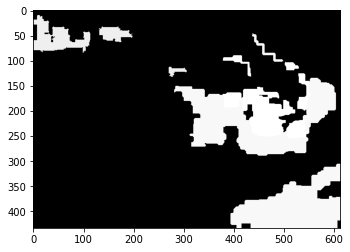

In [ ]:
def get_ut_final_clusters(foregrounds, masks, clusters, thresh=30, image_type="LT", year=2008, month=5, n_clusters=11, cluster_type="kmeans"):
  """
  This function gets the final UT clusters
  """
  all_seuils = list()

  pollution_images = list()

  for dd in range(len(clusters)):
    
    if cluster_type == "kmeans":
      image_cluster = clusters[dd][0]
    elif cluster_type == "spectral":
      image_cluster = clusters[dd][1]
    elif cluster_type == "agglo":
      image_cluster = clusters[dd][2]
    elif cluster_type == "optics":
      image_cluster = clusters[dd][3]
    else:
      image_cluster = clusters[dd][0]

    image_foreground = foregrounds[dd]
    image_masked = masks[dd]
    im_acum = np.zeros(image_cluster.shape, np.uint8)
  
    for cl in range(1,n_clusters):
      im_orig = np.zeros(image_cluster.shape, np.uint8)
      im_orig = np.where(image_cluster == cl,1, im_orig)
      contours_orig, _ = cv2.findContours(im_orig, 1, 2)

      for i,cnt in enumerate(contours_orig):
        box = cv2.boundingRect(cnt)
        x,y,w,h = box
        if ( w*h ) > 1000:
          g = get_region_value2(image_masked,box,image_foreground)
          im_acum = np.where(image_cluster == cl, g, im_acum)
          #im_orig = np.where(image_cluster == cl,g, im_orig)
      im_acum = np.where(im_acum < thresh, 0, im_acum)
    pollution_images.append(im_acum)

  return pollution_images


pollution_ut2 = get_ut_final_clusters(all_foreground_ut,all_masks_ut,all_images_cluster_ut,34,"UT",2008,5,10,cluster_type="kmeans")
plt.imshow(pollution_ut2[5], cmap="gray")

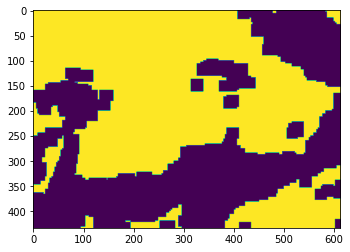

In [ ]:
plt.imshow(all_foreground_ut[5])

In [ ]:
def plot_final_clusters(foregrounds, masks, clusters, thresh=30, image_type="LT", year=2008, month=5, n_clusters=11):
  """
  This function plot the clusters with the defined threshold
  """
  all_seuils = list()

  x_range = [100, 150, 10]
  y_range = [20, 48, 5]

  for dd in range(len(clusters)):
    image_cluster = clusters[dd]
    image_foreground = foregrounds[dd]
    image_masked = masks[dd]
    im_acum = np.zeros(image_cluster.shape, np.uint8)
  
    for cl in range(1,n_clusters):
      im_orig = np.zeros(image_cluster.shape, np.uint8)
      im_orig = np.where(image_cluster == cl,1, im_orig)
      contours_orig, _ = cv2.findContours(im_orig, 1, 2)

      for i,cnt in enumerate(contours_orig):
        box = cv2.boundingRect(cnt)
        x,y,w,h = box
        if ( w*h ) > 1000:
          g = get_region_value2(image_masked,box,image_foreground)
          im_acum = np.where(image_cluster == cl, g, im_acum)
          #im_orig = np.where(image_cluster == cl,g, im_orig)
      im_acum = np.where(im_acum < thresh, 0, im_acum)

    fig, ax = plt.subplots(1,1)

    ax.imshow(im_acum, cmap="jet")
    ax.set_title("Cluster IASI - " + image_type + " "+str(dd+1)+"/"+str(month)+"/"+str(year))

In [ ]:
all_input_lt = list()
all_input_ut = list()

all_labels_lt = list()
all_labels_ut = list()

all_centers_lt = list()
all_centers_ut = list()

all_weights_lt = list()
all_weights_ut = list()

all_images_cluster_lt = list()
all_images_cluster_ut = list()

all_grays_vals_lt = list()
all_grays_vals_ut = list()

all_centroids_vals_lt = list()
all_centroids_vals_ut = list()

all_coords_vals_lt = list()
all_coords_vals_ut = list()

all_areas_vals_lt = list()
all_areas_vals_ut = list()

all_foreground_lt = list()
all_foreground_ut = list()

all_masks_lt = list()
all_masks_ut = list()

for i in range(1,12):
  print(str(i) + "---------------------------------------------------------------------------")
  #if i == 10 or i == 11 or i == 12:
  #  continue
  
  X_lt, labels_lt , weights_lt, gray_val_lt, centroid_val_lt, coords_regions_lt, areas_partition_lt, foreground_lt, mask_lt, total_centers_lt, total_cluster_lt = get_clusters_days(2008,5,i,"LT",35,7)
  X_ut, labels_ut , weights_ut, gray_val_ut, centroid_val_ut, coords_regions_ut, areas_partition_ut, foreground_ut, mask_ut, total_centers_ut, total_cluster_ut = get_clusters_days(2008,5,i,"UT",45,5)
  all_input_lt.append(X_lt)
  all_input_ut.append(X_ut)
  all_labels_lt.append(labels_lt)
  all_labels_ut.append(labels_ut)
  all_weights_lt.append(weights_lt)
  all_weights_ut.append(weights_ut)
  all_coords_vals_lt.append(coords_regions_lt)
  all_coords_vals_ut.append(coords_regions_ut)
  all_grays_vals_lt.append(gray_val_lt)
  all_grays_vals_ut.append(gray_val_ut)
  all_areas_vals_lt.append(areas_partition_lt)
  all_areas_vals_ut.append(areas_partition_ut)
  all_centroids_vals_lt.append(centroid_val_lt)
  all_centroids_vals_ut.append(centroid_val_ut)
  all_foreground_lt.append(foreground_lt)
  all_foreground_ut.append(foreground_ut)
  all_masks_lt.append(mask_lt)
  all_masks_ut.append(mask_ut)
  all_centers_lt.append(total_centers_lt)
  all_centers_ut.append(total_centers_ut)
  all_images_cluster_lt.append(total_cluster_lt)
  all_images_cluster_ut.append(total_cluster_ut)

1---------------------------------------------------------------------------
reading info ...
data have been read correctly
REGIONS found with MSER 491
Total connected components 2202
props 2202
clustering...
Cluster finished.
Class finished
reading info ...
data have been read correctly
REGIONS found with MSER 71
Total connected components 878
props 878
clustering...
Cluster finished.
Class finished
2---------------------------------------------------------------------------
reading info ...
data have been read correctly
REGIONS found with MSER 338
Total connected components 1533
props 1533
clustering...
Cluster finished.
Class finished
reading info ...
data have been read correctly
REGIONS found with MSER 67
Total connected components 387
props 387
clustering...
Cluster finished.
Class finished
3---------------------------------------------------------------------------
reading info ...
data have been read correctly
REGIONS found with MSER 421
Total connected components 1683
props 16

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total connected components 2113
props 2113
clustering...
Cluster finished.
Class finished
reading info ...
data have been read correctly
REGIONS found with MSER 70
Total connected components 1117
props 1117
clustering...
Cluster finished.
Class finished
7---------------------------------------------------------------------------
reading info ...
data have been read correctly
REGIONS found with MSER 438
Total connected components 1848
props 1848
clustering...
Cluster finished.
Class finished
reading info ...
data have been read correctly
REGIONS found with MSER 69


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total connected components 333
props 333
clustering...
Cluster finished.
Class finished
8---------------------------------------------------------------------------
reading info ...
data have been read correctly
REGIONS found with MSER 506
Total connected components 2468
props 2468
clustering...
Cluster finished.
Class finished
reading info ...
data have been read correctly
REGIONS found with MSER 83
Total connected components 567
props 567
clustering...
Cluster finished.
Class finished
9---------------------------------------------------------------------------
reading info ...
data have been read correctly
REGIONS found with MSER 528
Total connected components 2422
props 2422
clustering...
Cluster finished.
Class finished
reading info ...
data have been read correctly
REGIONS found with MSER 68
Total connected components 502
props 502
clustering...
Cluster finished.
Class finished
10---------------------------------------------------------------------------
reading info ...
data have

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


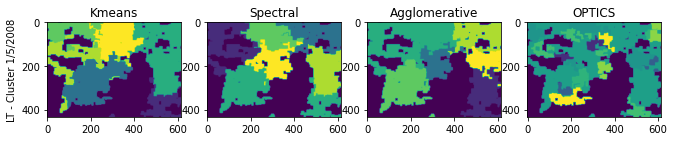

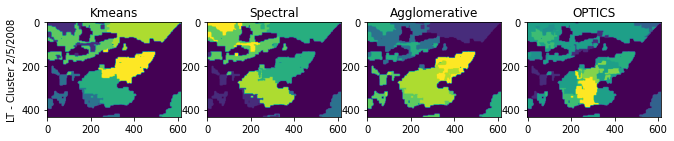

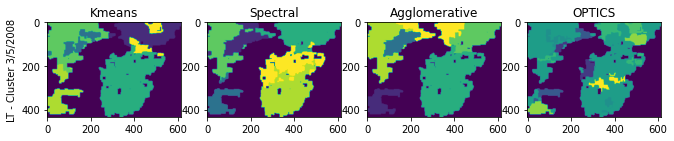

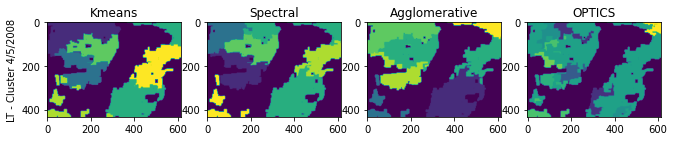

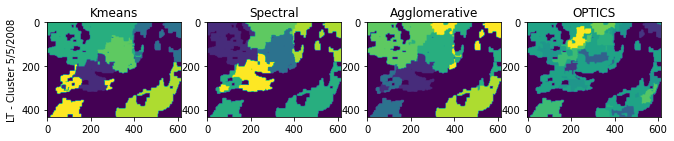

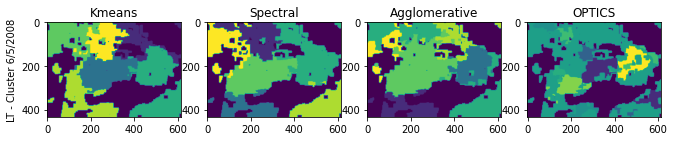

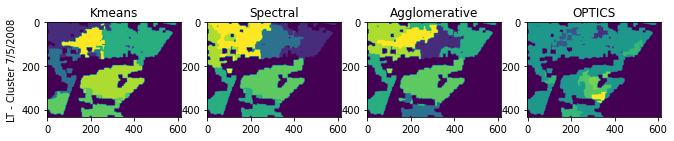

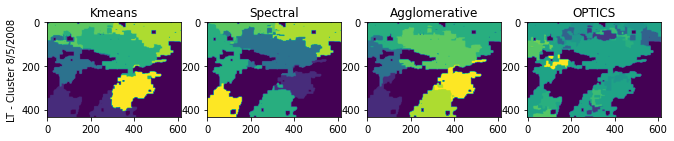

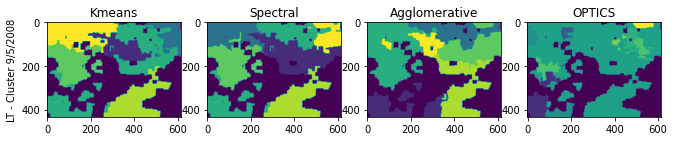

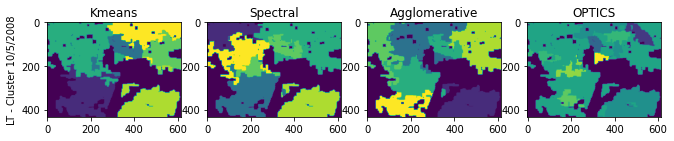

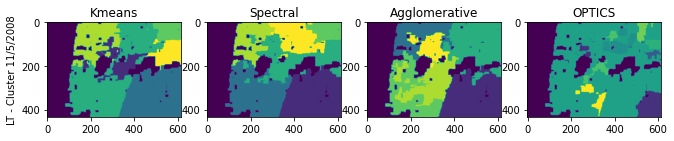

Error in callback <function flush_figures at 0x7f6b7d6d54d0> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
for i in range(len(all_images_cluster_lt)):
  f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(11,8))
  ax1.set_title("Kmeans")
  ax1.set_ylabel("LT - Cluster " + str(i+1) + "/5/2008")
  ax1.imshow(all_images_cluster_lt[i][0])
  ax2.set_title("Spectral")
  ax2.imshow(all_images_cluster_lt[i][1])
  ax3.set_title("Agglomerative")
  ax3.imshow(all_images_cluster_lt[i][2])
  ax4.set_title("OPTICS")
  ax4.imshow(all_images_cluster_lt[i][3])

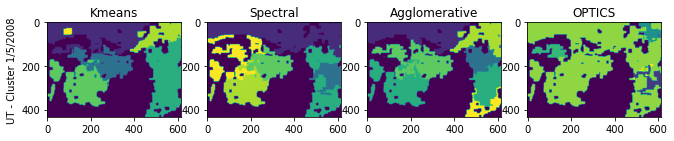

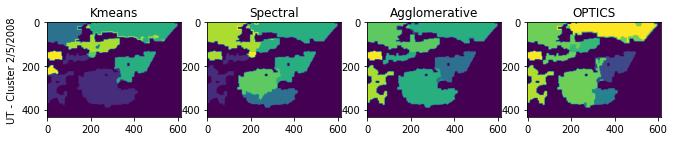

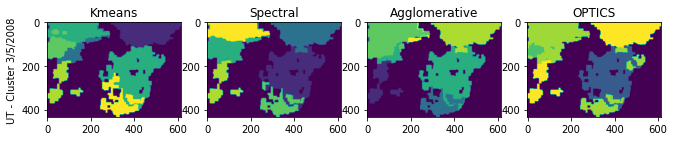

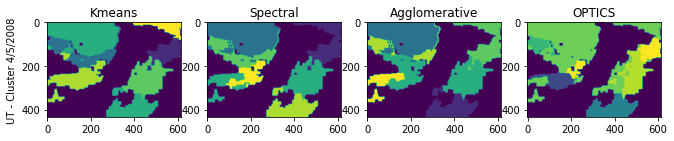

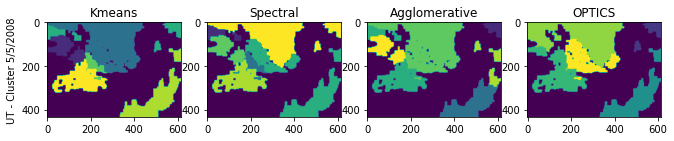

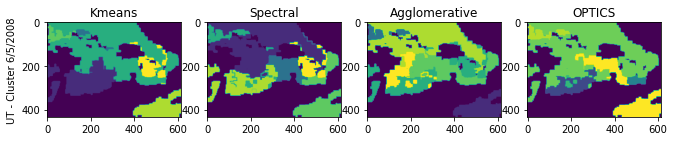

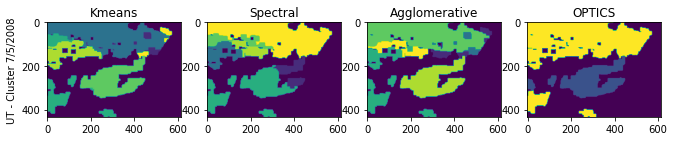

In [ ]:
for i in range(len(all_images_cluster_ut)):
  f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(11,8))
  ax1.set_title("Kmeans")
  ax1.set_ylabel("UT - Cluster " + str(i+1) + "/5/2008")
  ax1.imshow(all_images_cluster_ut[i][0])
  ax2.set_title("Spectral")
  ax2.imshow(all_images_cluster_ut[i][1])
  ax3.set_title("Agglomerative")
  ax3.imshow(all_images_cluster_ut[i][2])
  ax4.set_title("OPTICS")
  ax4.imshow(all_images_cluster_ut[i][3])

In [ ]:
# Do not delete
CLUSTER_TYPE = "kmeans"
print(CLUSTER_TYPE)

kmeans


In [ ]:
sens_lt, spec_lt, prec_lt, acc_lt, jacc_lt, range_lt = get_cluster_data_results(all_foreground_lt[:], 
                          all_masks_lt[:], 
                          all_images_cluster_lt[:], 
                          all_labels_lt[:], 
                          year=2008, 
                          month=5, 
                          image_type="LT",
                          cluster_type=CLUSTER_TYPE)

In [ ]:
sens_ut, spec_ut, prec_ut, acc_ut, jacc_ut, range_ut = get_cluster_data_results(all_foreground_ut[:], 
                          all_masks_ut[:], 
                          all_images_cluster_ut[:], 
                          all_labels_ut[:], 
                          year=2008, 
                          month=5, 
                          image_type="UT",
                          cluster_type=CLUSTER_TYPE)

max available range 22
Mean sensitivity 0.8360568663366762
Mean specificity 0.504128318605684
Mean precision 0.8012588238174114
Mean accuracy 0.5756208561412252
Mean Jaccard Coef. 0.45000600890231846


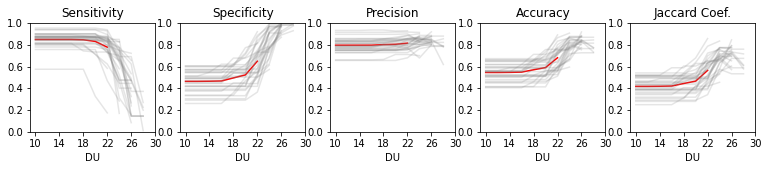

In [ ]:
plot_results_graph_by_cluster(sens_lt,spec_lt,prec_lt,acc_lt,jacc_lt,range_lt,"LT")

max available range 34
Mean sensitivity 0.755539216115407
Mean specificity 0.7232429917129388
Mean precision 0.7977188874892042
Mean accuracy 0.7311043925435119
Mean Jaccard Coef. 0.6050535253072914


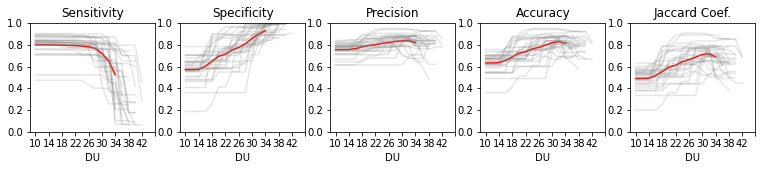

In [ ]:
plot_results_graph_by_cluster(sens_ut,spec_ut,prec_ut,acc_ut,jacc_ut,range_ut,"UT")

In [ ]:
# to visualize
##compare_with_ground_truth(all_foreground_ut[:2], all_masks_ut[:2], all_images_cluster_ut[:2], 2008, 5, "UT",True)
#compare_with_ground_truth(all_foreground_lt[:], 
#                          all_masks_lt[:], 
#                          all_images_cluster_lt[:], 
#                          all_labels_lt[:], 
#                          year=2008, 
#                          month=5, 
#                          image_type="LT",
#                          plot=True,
#                          max_range=35,
#                          cluster_type=CLUSTER_TYPE)

In [ ]:
#clusters_target_lt = compare_clusters_individually(all_foreground_lt,all_masks_lt,all_images_cluster_lt, all_labels_lt)
#all_regions_target_lt = assign_cluster_target_to_regions(all_labels_lt,clusters_target_lt)

In [ ]:
#clusters_target_ut = compare_clusters_individually(all_foreground_ut,all_masks_ut,all_images_cluster_ut[0], all_labels_ut)
#all_regions_target_ut = assign_cluster_target_to_regions(all_labels_ut,clusters_target_ut)

In [ ]:
#for day in range(1,8):
#  id = day - 1
#  mm = get_highest_region(all_images_cluster_lt[id], clusters_target_lt[id], all_labels_lt[id], all_centroids_vals_lt[id], all_coords_vals_lt[id], all_grays_vals_lt[id], all_areas_vals_lt[id],day)
#  print(np.mean(mm), np.max(mm), np.min(mm))

In [ ]:
lt_fp, lt_fn = compare_with_ground_truth(all_foreground_lt, all_masks_lt, all_images_cluster_lt, all_labels_lt, 2008, 5, "LT", cluster_type=CLUSTER_TYPE)

In [ ]:
ut_fp, ut_fn = compare_with_ground_truth(all_foreground_ut, all_masks_ut, all_images_cluster_ut, all_labels_ut, 2008, 5, "UT", max_range=45, cluster_type=CLUSTER_TYPE)

In [ ]:
# 10 - 12 - 14 - 16 - 18 - 20 - 22 - 24 - 26 - 28 - 30 - 32 - 34
# 0  - 1  - 2 -  3  - 4  - 5  - 6  - 7 -  8  - 9  - 10 - 11 - 12

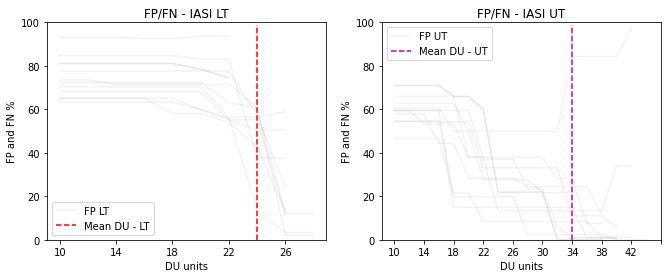

In [ ]:

#t_p_plot = np.where(np.array(all_true_positives_c) > 0, all_true_positives_c, np.nan)

fig, (ax,ax2) = plt.subplots(1,2,figsize=(11,4))

##ax.plot( np.arange(len(all_true_positives_c)), all_true_positives_c, label="True Positives")
#ax.plot( np.arange(len(all_false_positives_c)), all_false_positives_c, label="False Positives")
#ax.plot( np.arange(len(all_false_negatives_c)), all_false_negatives_c, label="False Negatives")

for i,fps in enumerate(lt_fp):
  if i == 0:
    ax.plot( np.arange(len(fps)), fps, c="gray", label="FP LT",alpha=0.1)
  ax.plot( np.arange(len(fps)), fps, c="gray",alpha=0.1)
#for i,fns in enumerate(lt_fn):
#  if i == 0:
#    ax.plot( np.arange(len(fns)), fns, c="b", label="FN LT")
#  ax.plot( np.arange(len(fns)), fns, c="b")


for i,fps in enumerate(ut_fp):
  if i == 0:
    ax2.plot( np.arange(len(fps)), fps, c="gray", label="FP UT",alpha=0.1)
  ax2.plot( np.arange(len(fps)), fps, c="gray",alpha=0.1)
#for i,fps in enumerate(ut_fn):
#  if i == 0:
#    ax.plot( np.arange(len(fps)), fps, c="b", label="FN UT")
#  ax.plot( np.arange(len(fps)), fps, c="b")

du_thresh_lt, du_best_value_lt = get_best_DU(lt_fp,lt_fn, "LT")
du_thresh_ut, du_best_value_ut = get_best_DU(ut_fp,ut_fn, "UT")

line_lt = np.full((100,), int(du_thresh_lt))
ax.plot(line_lt, np.arange(len(line_lt)), "--", label="Mean DU - LT", c="r")

line_ut = np.full((100,), int(du_thresh_ut))
ax2.plot(line_ut, np.arange(len(line_ut)), "--", label="Mean DU - UT", c="m")

ax.set_title('FP/FN - IASI LT')# + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year))
ax.set_xlabel("DU units")
ax.set_ylabel("FP and FN %")
ax.set_ylim([0,100])

ax2.set_title('FP/FN - IASI UT')# + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year))
ax2.set_xlabel("DU units")
ax2.set_ylabel("FP and FN %")
ax2.set_ylim([0,100])

ax.set_xticks(np.arange(0,10,2))
ax.set_xticklabels(np.arange(10,35,4))

ax2.set_xticks(np.arange(0,20,2))
ax2.set_xticklabels(np.arange(10,45,4))


ax.legend()
ax2.legend()


plt.show()

In [ ]:
print("Best DU for UT", int(du_best_value_ut))
print("Best DU for LT", int(du_best_value_lt))

Best DU for UT 34
Best DU for LT 24


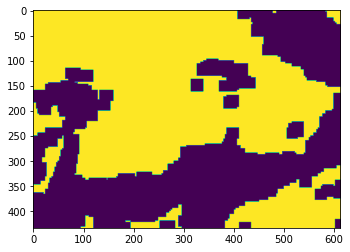

In [ ]:
plt.imshow(all_foreground_ut[5])

In [ ]:
pollution_ut = get_ut_final_clusters(all_foreground_ut,all_masks_ut,all_images_cluster_ut,int(du_best_value_ut),"UT",2008,5,6,cluster_type=CLUSTER_TYPE)

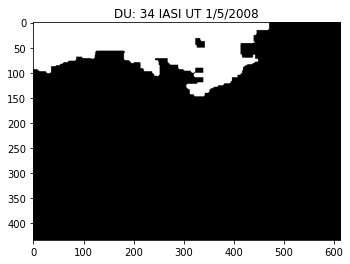

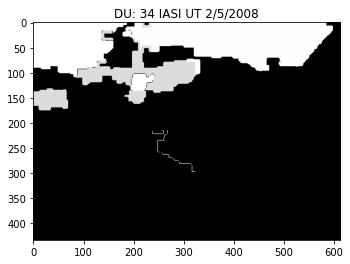

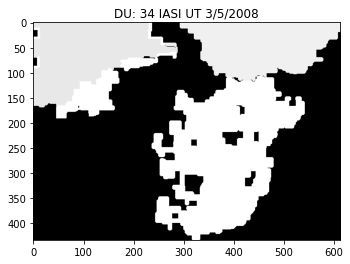

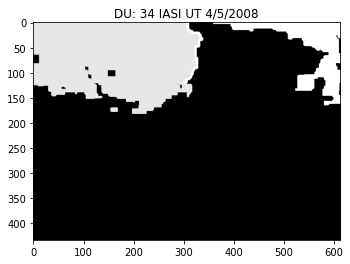

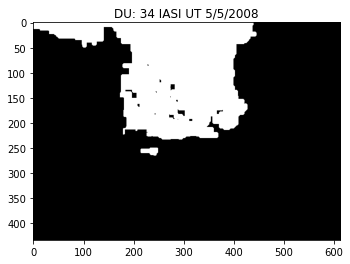

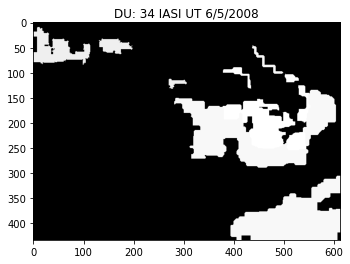

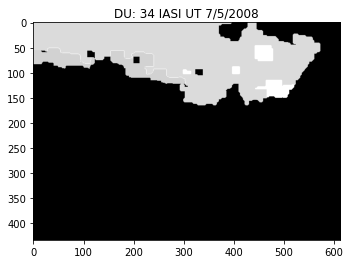

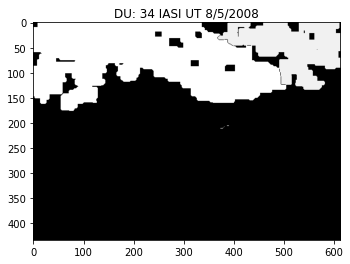

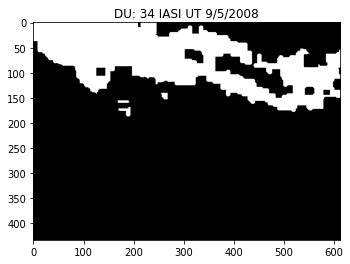

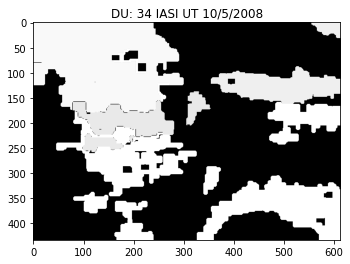

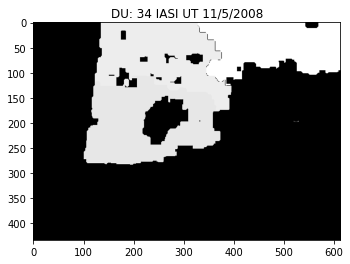

In [ ]:
for i in range(11):
  fig, ax = plt.subplots(1,1)
  ax.set_title("DU: " + str(int(du_best_value_ut)) + " IASI UT " + str(i+1) + "/5/2008")
  ax.imshow(pollution_ut[i], cmap="gray")

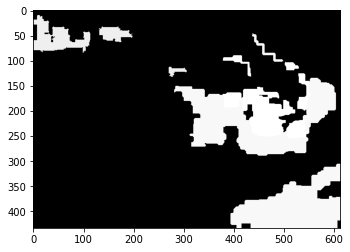

In [ ]:
pollution_ut2 = get_ut_final_clusters(all_foreground_ut,all_masks_ut,all_images_cluster_ut,34,"UT",2008,5,6,cluster_type="kmeans")
plt.imshow(pollution_ut2[5], cmap="gray")

In [ ]:
WEIGHT = 2
N_CLUSTERS = 7
day_to_test = 6

pollution2 = PollutionTracker()
pollution2.set_year(2008)
pollution2.set_month(5)
pollution2.set_day(day_to_test)
pollution2.set_image_type("LT")
pollution2.set_vmin(10)
pollution2.set_vmax(35)
pollution2.set_image_name("levels")
pollution2.set_weight_gray_values(1)
pollution2.set_cluster_value(30)
pollution2.set_pixel_size(0.25,.125)
pollution2.get_image_by_leves()

image_gray_in, image_bgr_in = pollution2.get_pollution_highest_ut(pollution_ut, day_to_test)
image_gray_out, image_bgr_out = pollution2.get_pollution_highest_lt(pollution_ut, day_to_test)
#pollution2.plot_hierarchical_pollution(image_gray_in)

Class finished
reading info ...
data have been read correctly


REGIONS found with MSER 448


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total connected components 1535
props 1535


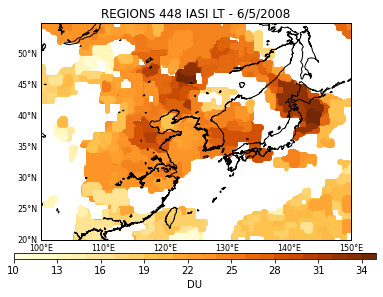

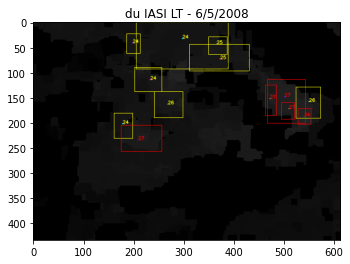

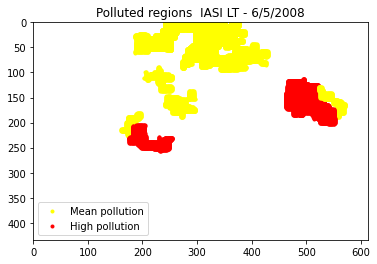

In [ ]:
image_gray = image_gray_out.copy()

image, foreground, background = pollution2.filter_image(image_gray)
image,image_rbg,image_masked = pollution2.filter_image_for_mser(image,foreground)
regions_mser, boxes_mser = pollution2.get_mser_regions(image_rbg)

regx, regy, regs, polys, lines, values = pollution2.set_mser_regions(image_masked, regions_mser)

pollution2.create_label(image_masked,regx, regy, values)
image_projected,image_projected_mask = pollution2.export_colored_region_image()

labels_cc, num_cc = pollution2.reconstruct_connected_component(image_projected_mask)
centroids, grays_values, areas_partition, boxes_partition, ids_valid_regions, coords_regions = pollution2.reconstruct_region_props(image_projected_mask, labels_cc, 500)

#pollution2.plot_inner_outer_regions(image_masked, regx, regy, values,image_projected, centroids, areas_partition, grays_values,boxes_partition,ids_valid_regions,'du',np.mean(grays_values))
pollution2.plot_mser_final_regions(image_masked, regx, regy, values)
pollution2.plot_regions_reconstructed(image_projected, centroids, areas_partition, grays_values,boxes_partition,ids_valid_regions,'du', du_best_value_lt )

highest_list_data = list() # stores a small list with the highest values -> this because i want to hierarchise the colors (red=high pollution) (yellow=mean pollution)

for gray in grays_values:
  if gray > du_best_value_lt:
    highest_list_data.append(gray)

fig3,ax3 = plt.subplots(1,1)
islabel1 = False
islabel2 = False

for i,r in enumerate(coords_regions):
  
  caa = [c[0] for c in r]
  daa = [d[1] for d in r]
  
  if grays_values[i] > du_best_value_lt:
    if grays_values[i] > np.mean(highest_list_data):
      if islabel1 == False:
        ax3.scatter(daa,caa,marker='.',color="red", label="High pollution")
        islabel1 = True
      ax3.scatter(daa,caa,marker='.',color="red")
    else:
      if islabel2 == False:
        ax3.scatter(daa,caa,marker='.',color="yellow", label="Mean pollution")
        islabel2 = True
      ax3.scatter(daa,caa,marker='.', color="yellow")
    xrange1 = [0, image_projected_mask.shape[1]]
    yrange1 = [0, image_projected_mask.shape[0]]
    ax3.set_xlim(*xrange1)
    ax3.set_ylim(*yrange1)
    ax3.set_title("Polluted regions " + pollution2.get_image_datename())
    ax3.legend()
    ax3.invert_yaxis()


REGIONS found with MSER 54
Total connected components 201
props 201


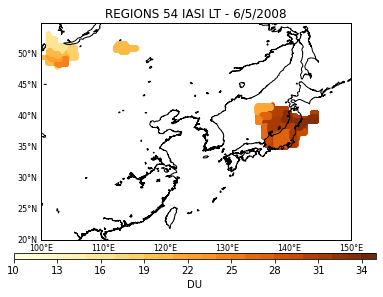

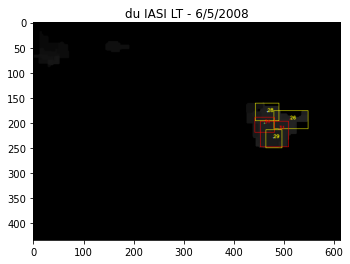

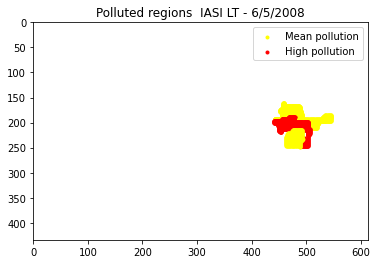

In [ ]:
image_gray = image_gray_in.copy()

image, foreground, background = pollution2.filter_image(image_gray)
image,image_rbg,image_masked = pollution2.filter_image_for_mser(image,foreground)
regions_mser, boxes_mser = pollution2.get_mser_regions(image_rbg)

regx, regy, regs, polys, lines, values = pollution2.set_mser_regions(image_masked, regions_mser)

pollution2.create_label(image_masked,regx, regy, values)
image_projected,image_projected_mask = pollution2.export_colored_region_image()

labels_cc, num_cc = pollution2.reconstruct_connected_component(image_projected_mask)
centroids, grays_values, areas_partition, boxes_partition, ids_valid_regions, coords_regions = pollution2.reconstruct_region_props(image_projected_mask, labels_cc, 500)

#pollution2.plot_inner_outer_regions(image_masked, regx, regy, values,image_projected, centroids, areas_partition, grays_values,boxes_partition,ids_valid_regions,'du',np.mean(grays_values))
pollution2.plot_mser_final_regions(image_masked, regx, regy, values)
pollution2.plot_regions_reconstructed(image_projected, centroids, areas_partition, grays_values,boxes_partition,ids_valid_regions,'du',du_best_value_lt)

highest_list_data = list() # stores a small list with the highest values -> this because i want to hierarchise the colors (red=high pollution) (yellow=mean pollution)

for gray in grays_values:
  if gray > du_best_value_lt:
    highest_list_data.append(gray)

fig3,ax3 = plt.subplots(1,1)
islabel1 = False
islabel2 = False

for i,r in enumerate(coords_regions):
  
  caa = [c[0] for c in r]
  daa = [d[1] for d in r]
  
  if grays_values[i] > np.mean(grays_values):
    if grays_values[i] > np.mean(highest_list_data):
      if islabel1 == False:
        ax3.scatter(daa,caa,marker='.',color="red", label="High pollution")
        islabel1 = True
      ax3.scatter(daa,caa,marker='.',color="red")
    else:
      if islabel2 == False:
        ax3.scatter(daa,caa,marker='.',color="yellow", label="Mean pollution")
        islabel2 = True
      ax3.scatter(daa,caa,marker='.', color="yellow")
    xrange1 = [0, image_projected_mask.shape[1]]
    yrange1 = [0, image_projected_mask.shape[0]]
    ax3.set_xlim(*xrange1)
    ax3.set_ylim(*yrange1)
    ax3.set_title("Polluted regions " + pollution2.get_image_datename())
    ax3.legend()
    ax3.invert_yaxis()

Class finished
reading info ...
data have been read correctly
REGIONS found with MSER 450
Total connected components 1546
props 1546


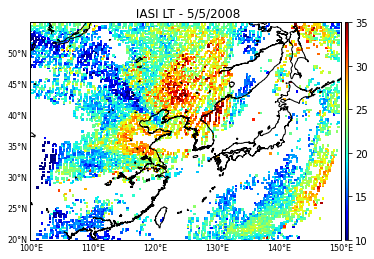

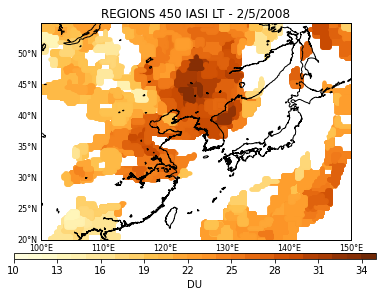

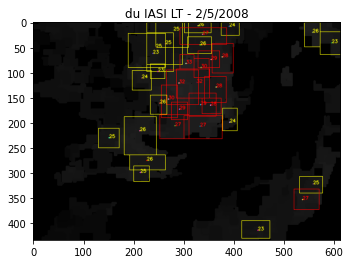

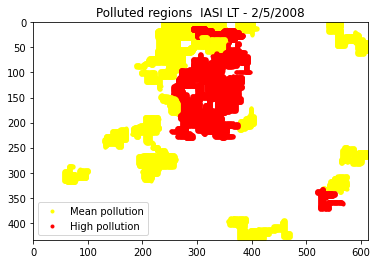

In [ ]:
WEIGHT = 2

pollution3 = PollutionTracker()
pollution3.set_year(2008)
pollution3.set_month(5)
pollution3.set_day(5)
pollution3.set_image_type("LT")
pollution3.set_vmin(10)
pollution3.set_vmax(35)
pollution3.set_image_name("levels")
pollution3.set_weight_gray_values(1)
pollution3.set_cluster_value(30)
pollution3.set_pixel_size(0.25,.125)
pollution3.get_image_by_leves()
image_bgr , image_gray = pollution3.load_image_from_files(pollution3.get_image_name())
image, foreground, background = pollution3.filter_image(image_gray)
image,image_rbg,image_masked = pollution3.filter_image_for_mser(image,foreground)
regions_mser, boxes_mser = pollution3.get_mser_regions(image_rbg)
regx, regy, regs, polys, lines, values = pollution3.set_mser_regions(image_masked, regions_mser)
pollution3.create_label(image_masked,regx, regy, values)
pollution3.plot_original_image()
image_projected,image_projected_mask = pollution3.export_colored_region_image()

labels_cc, num_cc = pollution2.reconstruct_connected_component(image_projected_mask)
centroids, grays_values, areas_partition, boxes_partition, ids_valid_regions, coords_regions = pollution2.reconstruct_region_props(image_projected_mask, labels_cc, 500)

#pollution2.plot_inner_outer_regions(image_masked, regx, regy, values,image_projected, centroids, areas_partition, grays_values,boxes_partition,ids_valid_regions,'du',np.mean(grays_values))
pollution2.plot_mser_final_regions(image_masked, regx, regy, values)
pollution2.plot_regions_reconstructed(image_projected, centroids, areas_partition, grays_values,boxes_partition,ids_valid_regions,'du',du_best_value_lt)

highest_list_data = list() # stores a small list with the highest values -> this because i want to hierarchise the colors (red=high pollution) (yellow=mean pollution)

for gray in grays_values:
  if gray > du_best_value_lt:
    highest_list_data.append(gray)

fig3,ax3 = plt.subplots(1,1)
islabel1 = False
islabel2 = False

for i,r in enumerate(coords_regions):
  
  caa = [c[0] for c in r]
  daa = [d[1] for d in r]
  
  if grays_values[i] > np.mean(grays_values):
    if grays_values[i] > np.mean(highest_list_data):
      if islabel1 == False:
        ax3.scatter(daa,caa,marker='.',color="red", label="High pollution")
        islabel1 = True
      ax3.scatter(daa,caa,marker='.',color="red")
    else:
      if islabel2 == False:
        ax3.scatter(daa,caa,marker='.',color="yellow", label="Mean pollution")
        islabel2 = True
      ax3.scatter(daa,caa,marker='.', color="yellow")
    xrange1 = [0, image_projected_mask.shape[1]]
    yrange1 = [0, image_projected_mask.shape[0]]
    ax3.set_xlim(*xrange1)
    ax3.set_ylim(*yrange1)
    ax3.set_title("Polluted regions " + pollution2.get_image_datename())
    ax3.legend()
    ax3.invert_yaxis()

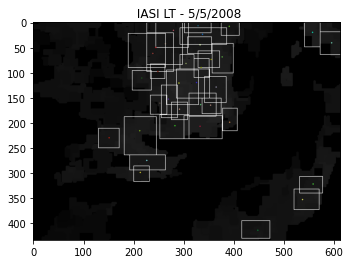

In [ ]:
# font

threshold = du_best_value_lt
image_projected,image_projected_mask = pollution3.export_colored_region_image()

font = cv2.FONT_HERSHEY_SIMPLEX
# Line thickness of 2 px
thickness = 1
#image_projected_color = cv2.cvtColor(image_projected, cv2.COLOR_GRAY2BGR)
fig, ax = plt.subplots(1,1) #, figsize=(11,8))
image_projected = cv2.cvtColor(image_projected, cv2.COLOR_GRAY2BGR)

ids_show = list()



highest_list_data = list() # stores a small list with the highest values -> this because i want to hierarchise the colors (red=high pollution) (yellow=mean pollution)

for gray in grays_values:
  if gray > threshold:
    highest_list_data.append(gray)

for i in range(len(centroids)):
    color = (random.randint(0,256), random.randint(0,256), random.randint(0,256))
    text = None


    # ID: str(i+1)
    # Area: str(areas_partition[i])
    # DU: str(int(imageLT.get_region_value(t_i,boxes_partition[i],True)))

    if grays_values[i] >= threshold:

      mean_highest = np.mean(highest_list_data)

      #if (grays_values[i] > mean_highest):
      #  bx_color = (255,0,0)
      #  tx_color = [255,0,0]
      #else:
      bx_color = (255,255,255)
      tx_color = [255,255,255]
            
      x, y, w, h = boxes_partition[i]
      
      ids_show.append(i)
      cv2.circle(image_projected, (int(centroids[i][1]), int(centroids[i][0])), 1, color, -1)
      cv2.rectangle(image_projected, (y,x), (h,w), bx_color, 1)

ax.imshow(image_projected)
ax.set_title(pollution3.get_image_datename())
fig.show()